In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2023-12-08 15:13:12.299744: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-12-08 15:13:14.836315: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 15:13:14.837209: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-12-08 15:13:15.215897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-12-08 15:13:15.218399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'

In [5]:
TS_PATH='TS'

In [6]:
images, labels = C.Helper.load_data(DATAPATH)

In [7]:
X_train, y_train, X_test, y_test = C.Helper.split_patients(images, labels)

In [8]:
#X_train, y_train, X_test, y_test = C.Helper.normalization(DATAPATH, X_train, y_train, X_test, y_test)

In [9]:
#slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
ts_id = []
for subfolder in os.listdir(TS_PATH):
    ts_id +=[int(subfolder)]

In [11]:
#ts_id

In [12]:
train_id=[]
for f in X_train:
    current_id = f.split('.')[0]
    train_id += [int(current_id)]

In [13]:
#train_id

In [14]:
test_id=[]
for f in X_test:
    current_id = f.split('.')[0]
    test_id += [int(current_id)]

In [15]:
#test_id

In [16]:
len(train_id), len(test_id)

(56, 14)

In [17]:
train=[]
#while True:
for i, t in enumerate(train_id):
    for j, c in enumerate(ts_id):
        if t == c:
            #print(i,j)
            #print(ts_id[j])
            #print(train_id[i])
            #print(j, i, ts_id[j], train_id[i])
            train.append((j, i))
            if len(train) == len(train_id):
                break

In [18]:
len(train)

56

In [19]:
#train

In [20]:
test=[]
#while True:
for i, t in enumerate(test_id):
    for j, c in enumerate(ts_id):
        if t == c:
            #print(i,j)
            #print(ts_id[j])
            #print(train_id[i])
            #print(j, i, ts_id[j], test_id[i])
            test.append((j, i))
            if len(test) == len(test_id):
                break

In [21]:
len(test)

14

In [22]:
#test

In [23]:
binary_masks = []
images=[]
image_patient=[]
label_patient=[]
results=[]
norm_X_train = []

for j, t in enumerate(train_id):
    for p, subfolder in enumerate(os.listdir(TS_PATH)):
        if t == int(subfolder):
            #print(p, j, subfolder, train_id[j])  

            subfolder_path = os.path.join(TS_PATH, str(subfolder))
            #print(subfolder_path)
            if os.path.isdir(subfolder_path):
                left_image_path = os.path.join(subfolder_path, 'common_carotid_artery_left.nii.gz')
                right_image_path = os.path.join(subfolder_path, 'common_carotid_artery_right.nii.gz')
                
                #print(subfolder, X_train[j])

                image, header = nrrd.read(DATAPATH + "/" + X_train[j])
                label, header = nrrd.read(DATAPATH + "/" + y_train[j])
                
                #normalize
                normalized_data = (image - np.min(image)) / (np.max(image) - np.min(image))
                #print(normalized_data.shape) #512,512,268
                
                bbox_plaque = mh.bbox(label)
                
                for i in range(normalized_data.shape[2]):
                    imgs = image[:,:,i]
                    image_patient.append(imgs)
                X_train_array = np.array(image_patient)
                
                for i in range(label.shape[2]):
                    labl = np.where(label[:,:,i] != 0, True, False)
                    label_patient.append(labl)
                y_train_array = np.array(label_patient)
                    
                if os.path.exists(left_image_path) and os.path.exists(right_image_path):
                    left_image = nib.load(left_image_path).get_fdata()
                    right_image = nib.load(right_image_path).get_fdata()

                    combined = left_image + right_image
                    bbox_combined = mh.bbox(combined)
                    
                    minimum = min(bbox_combined[4],bbox_plaque[4])
                    maximum = max(bbox_combined[5],bbox_plaque[5])


                    for i in range(combined.shape[2]):
                        img = combined[:, :, i]
                        T_otsu = threshold_otsu(img)
                        img = img > T_otsu
                        es = np.ones((50, 50), bool)
                        dilate_img = mh.morph.dilate(img,es)
                        bbox = mh.bbox(dilate_img)
                        

                        if i >= minimum and i <= maximum+1:
                            if np.all(bbox == 0):
                                bbox = [min(bbox_combined[0],bbox_plaque[0]),
                                        max(bbox_combined[1],bbox_plaque[1]),
                                        min(bbox_combined[2],bbox_plaque[2]),
                                        max(bbox_combined[3],bbox_plaque[3])]
                                dilate_img[bbox[0]:bbox[1], bbox[2]:bbox[3]] = 1

                        images.append(dilate_img)

In [24]:
for i in range(len(images)):
    binary = (images[i] > 0).astype(np.uint8) * 255
    binary_masks.append(binary)

In [25]:
#for i in range(len(image_patient)):
#    result = image_patient[i] * binary_masks[i]
#    results.append(result)

In [26]:
for i in range(len(X_train_array)):
    result = X_train_array[i] * binary_masks[i]
    results.append(result)

In [27]:
len(images), len(binary_masks),len(image_patient)

(13159, 13159, 13159)

In [28]:
len(X_train_array), len(y_train_array)

(13159, 13159)

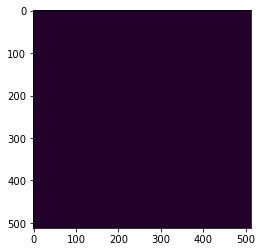

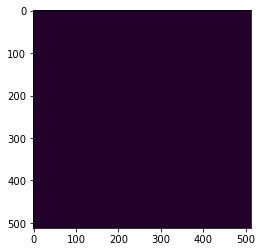

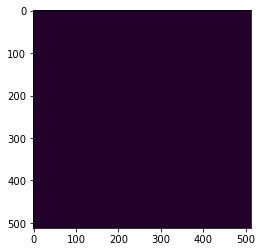

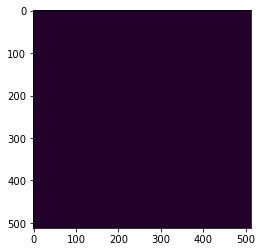

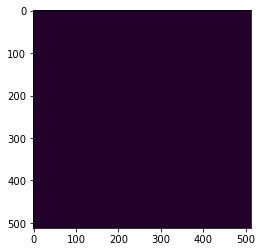

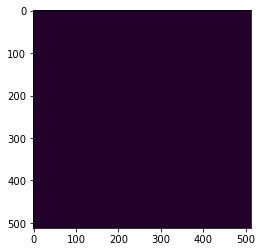

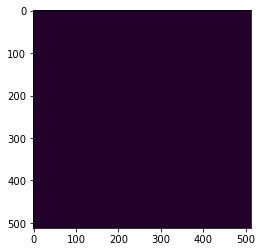

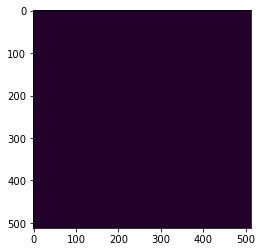

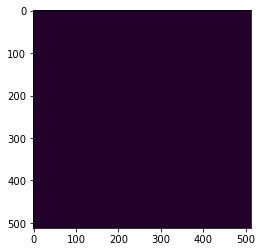

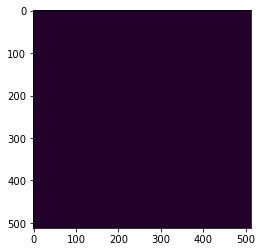

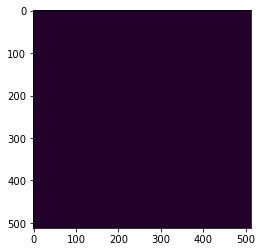

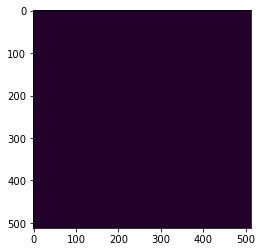

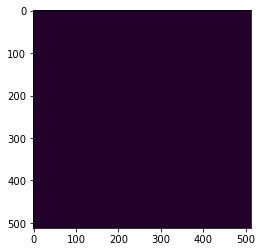

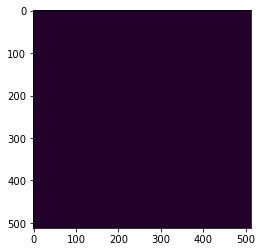

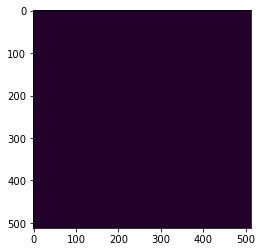

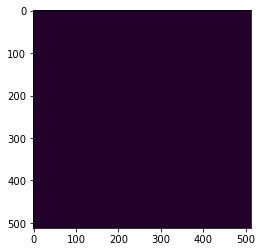

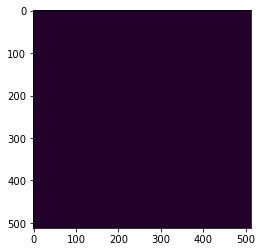

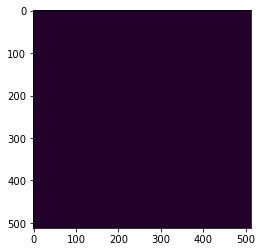

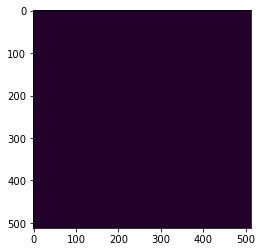

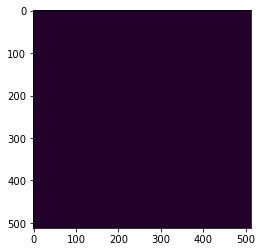

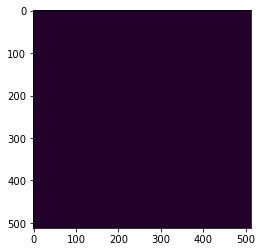

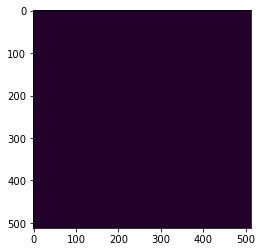

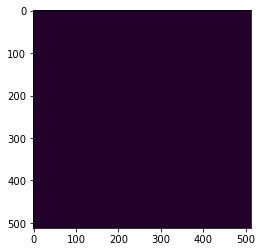

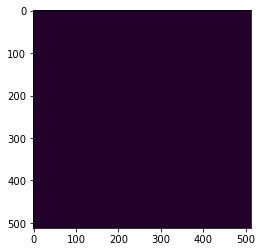

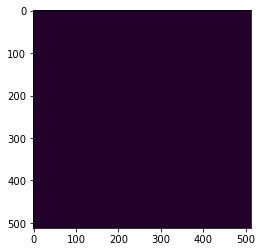

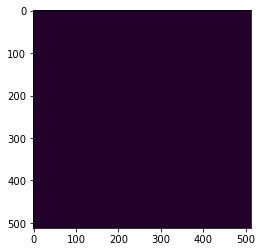

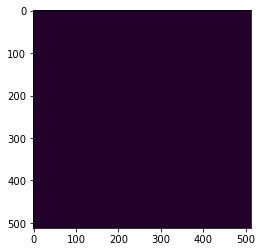

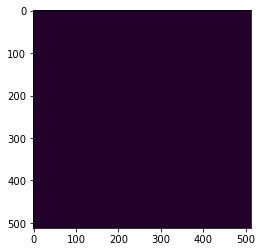

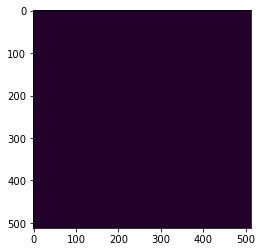

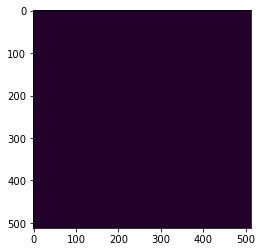

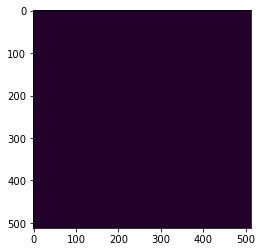

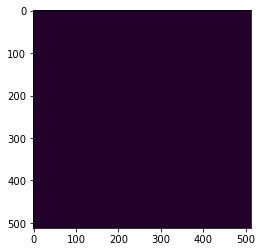

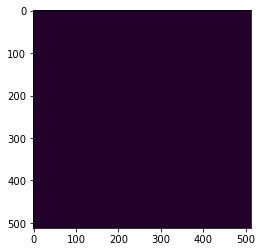

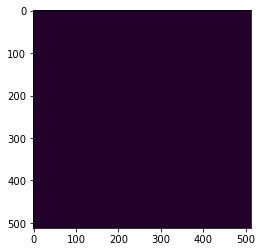

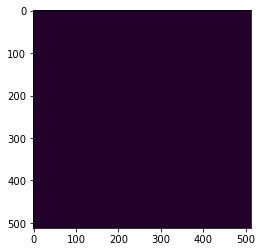

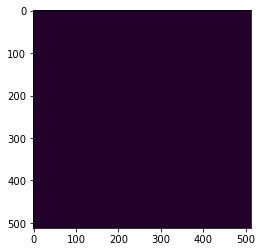

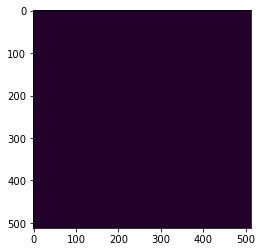

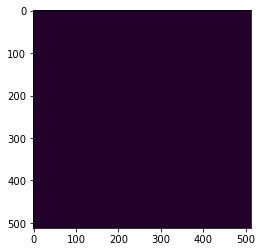

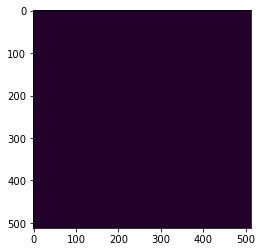

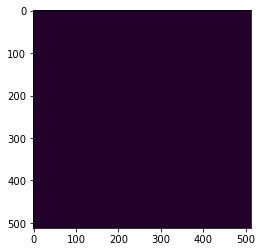

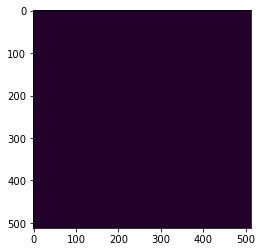

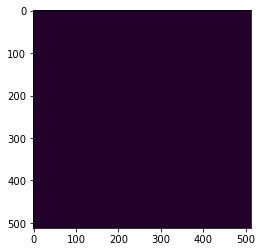

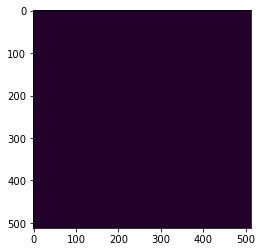

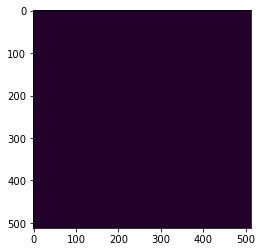

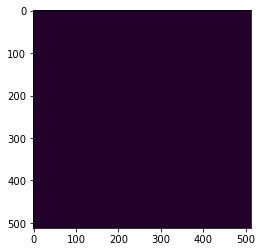

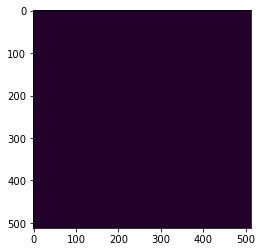

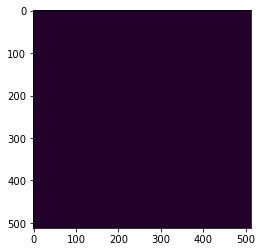

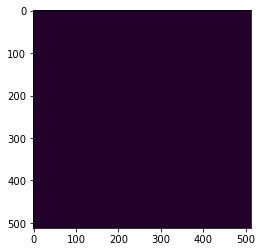

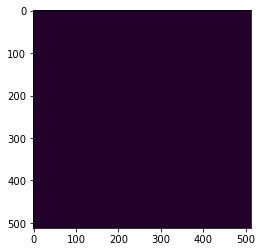

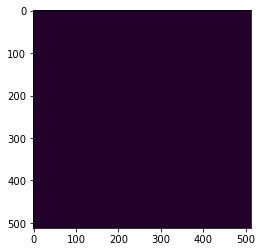

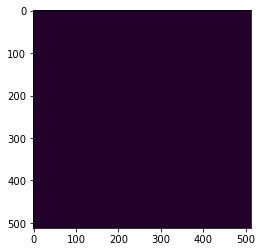

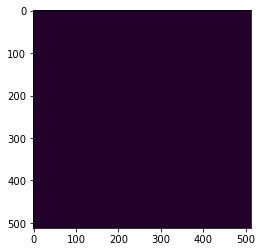

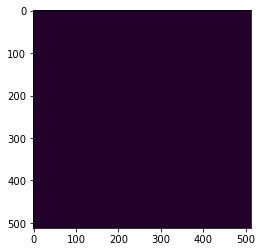

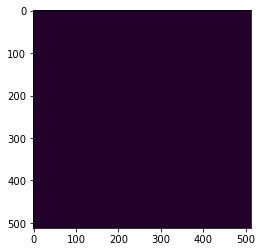

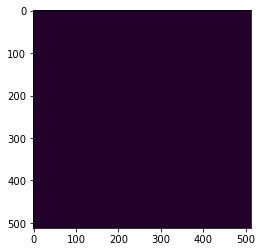

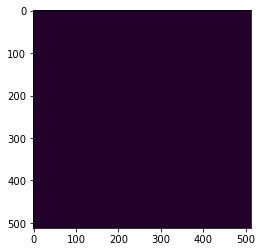

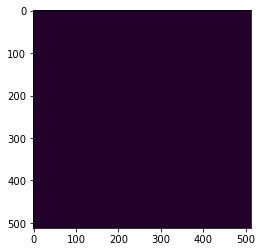

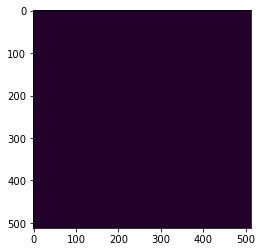

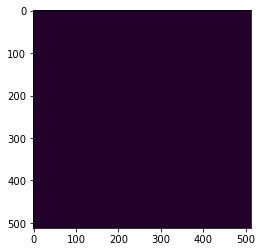

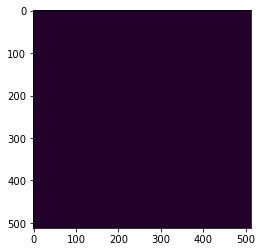

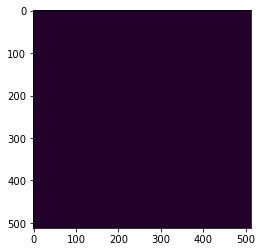

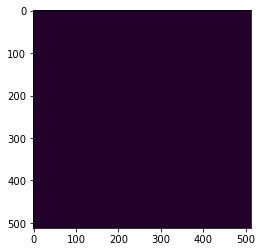

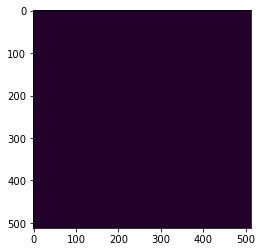

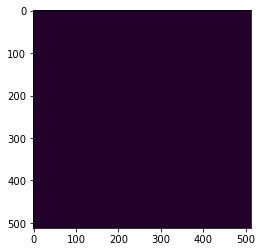

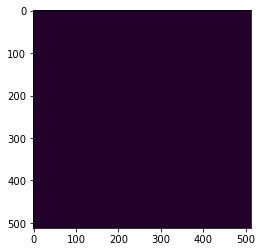

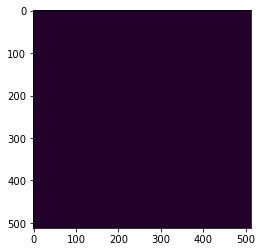

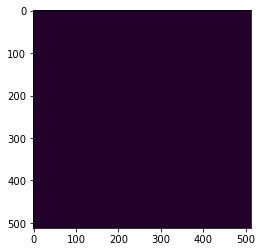

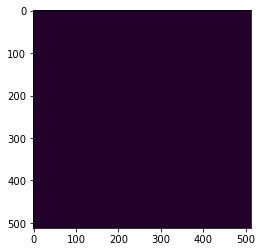

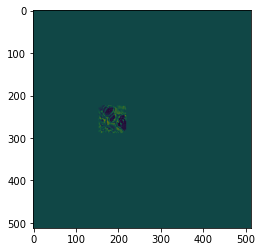

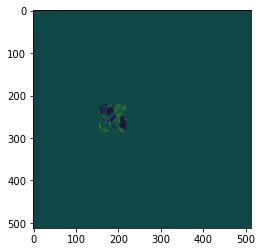

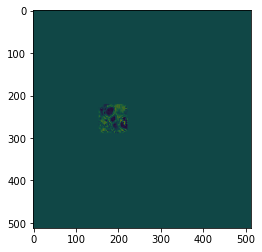

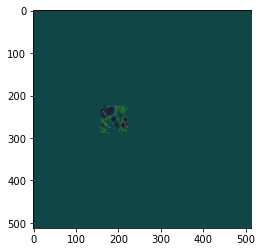

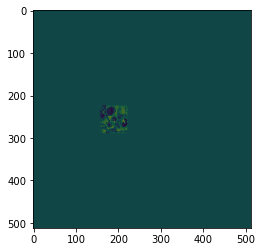

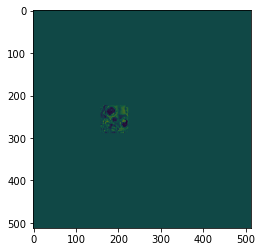

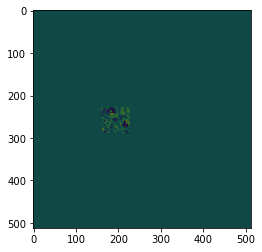

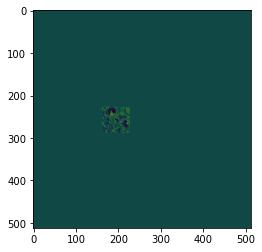

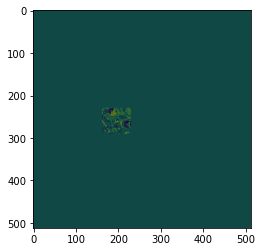

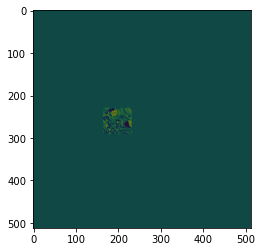

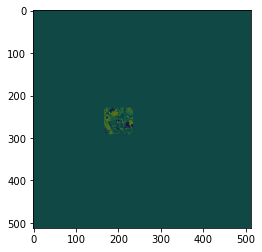

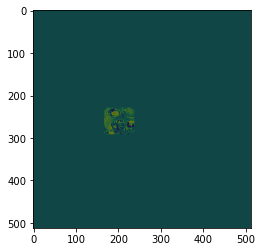

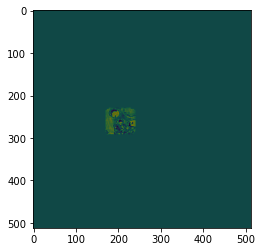

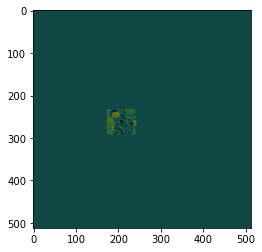

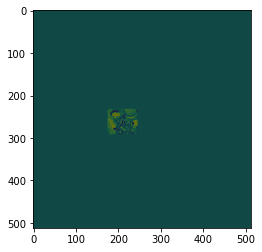

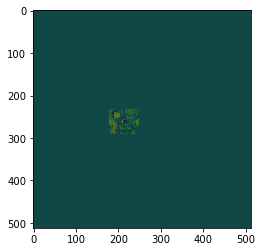

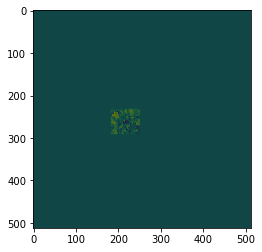

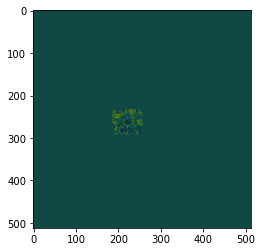

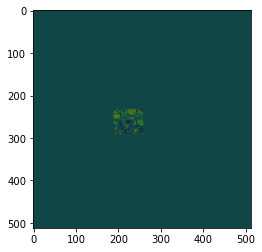

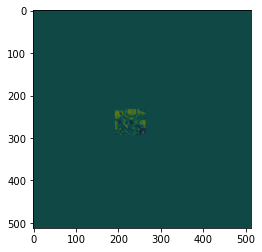

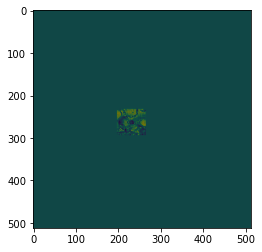

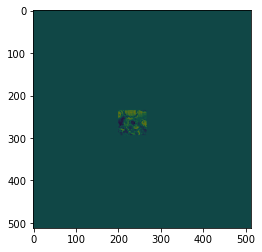

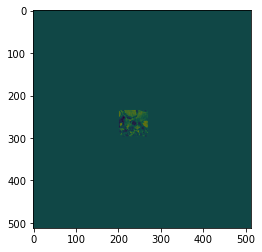

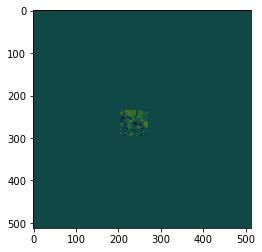

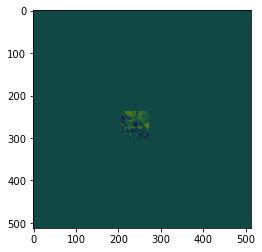

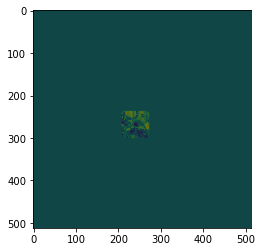

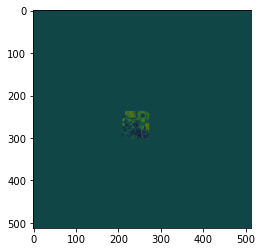

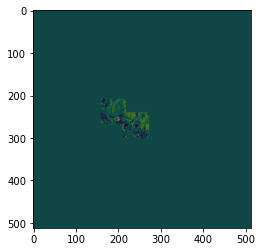

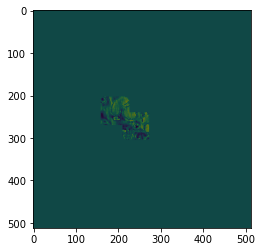

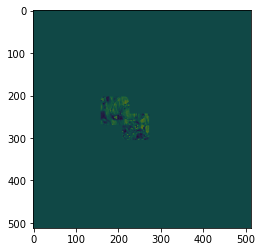

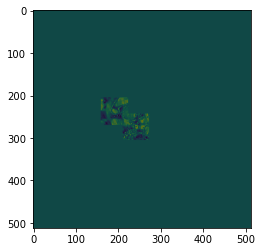

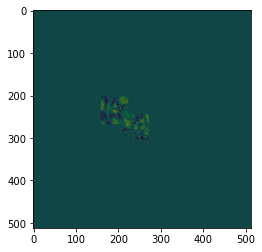

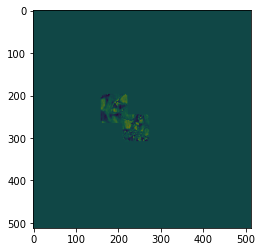

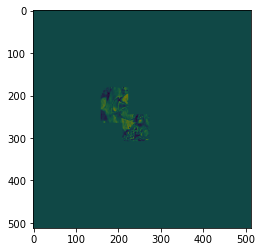

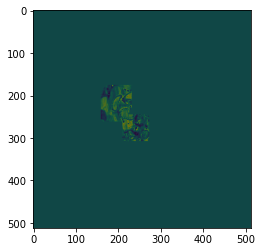

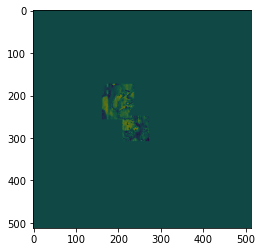

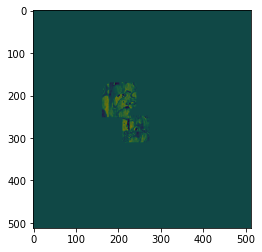

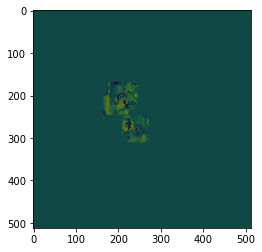

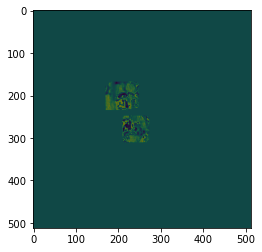

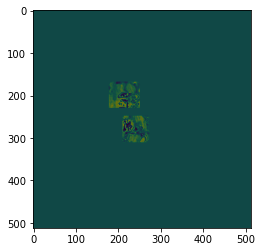

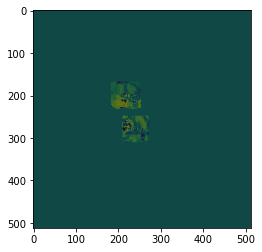

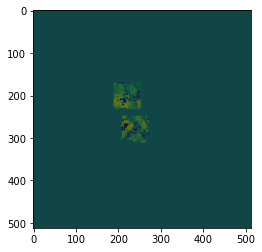

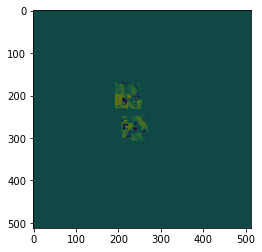

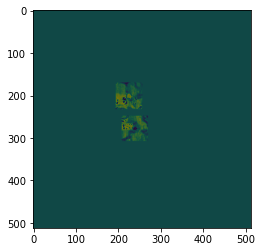

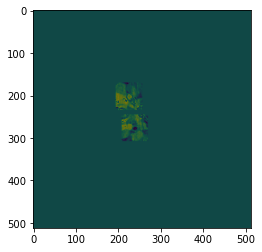

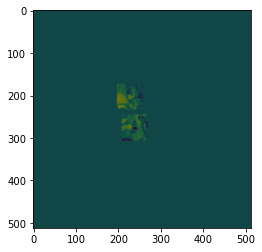

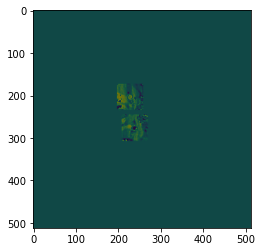

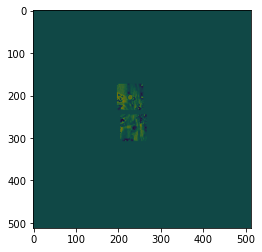

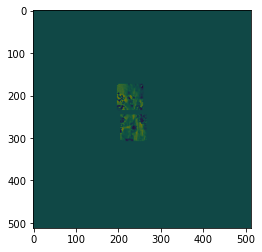

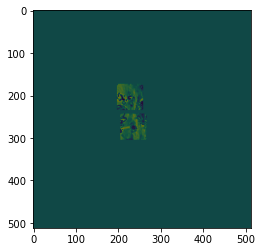

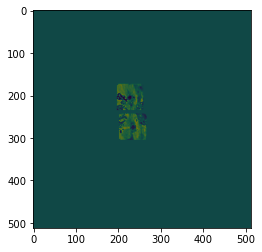

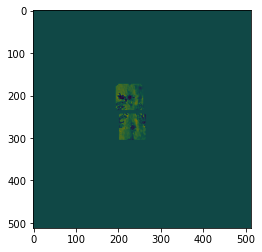

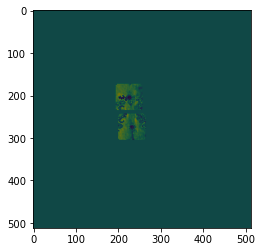

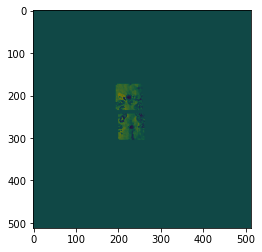

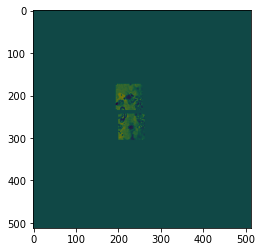

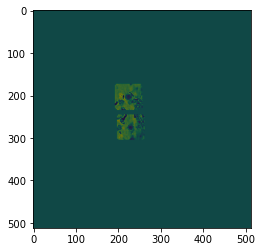

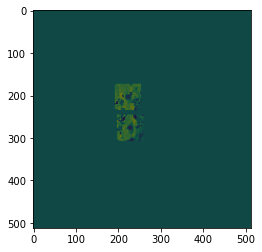

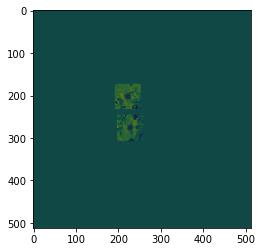

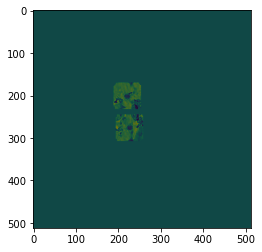

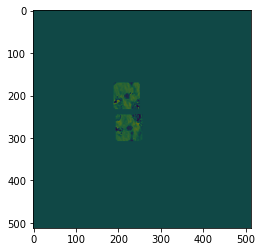

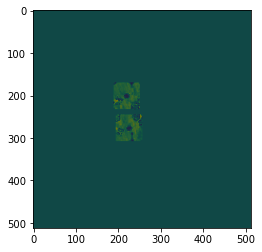

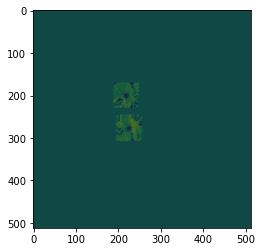

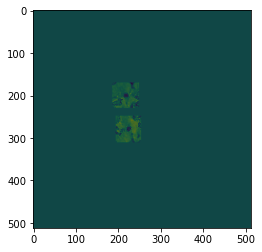

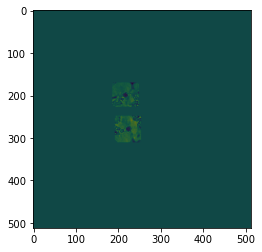

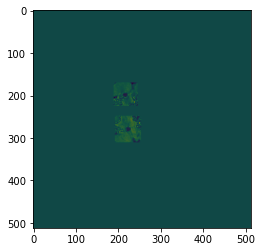

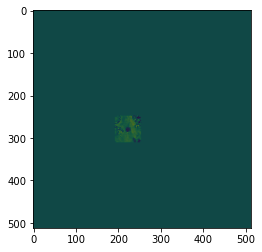

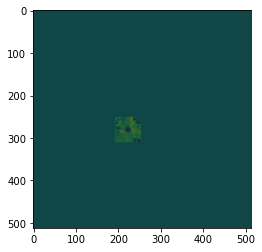

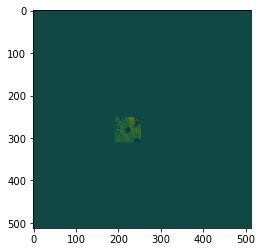

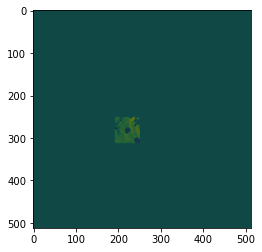

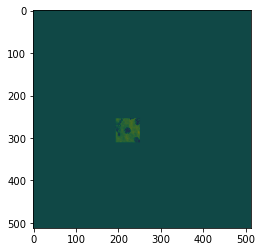

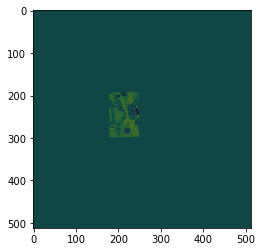

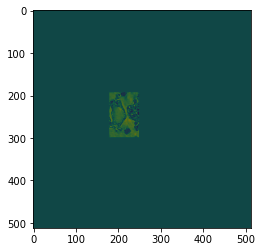

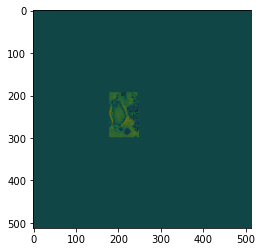

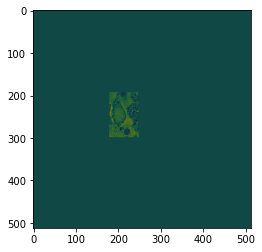

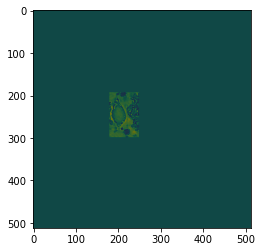

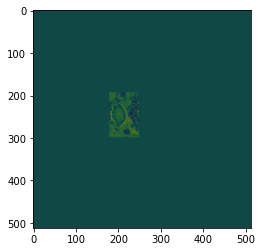

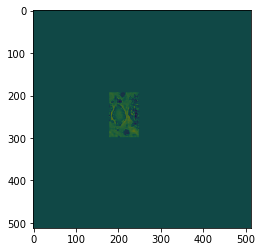

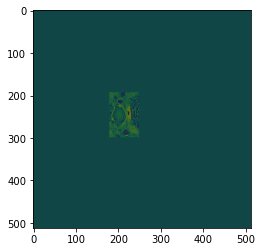

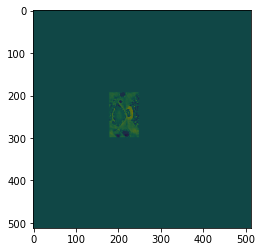

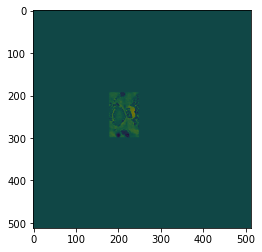

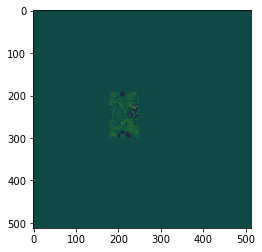

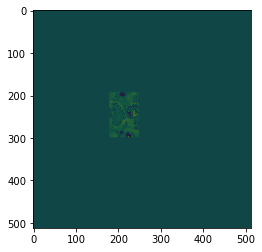

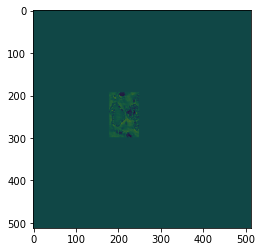

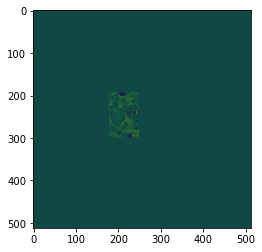

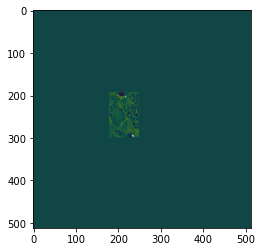

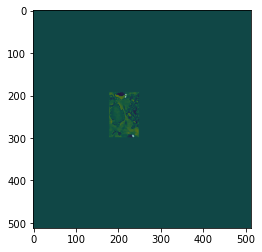

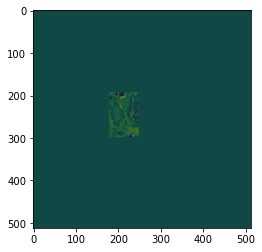

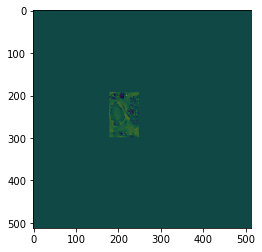

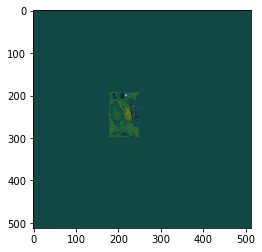

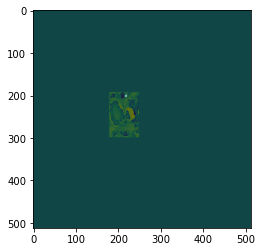

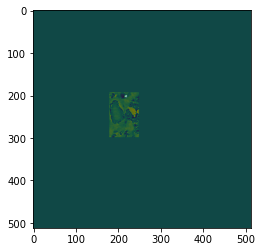

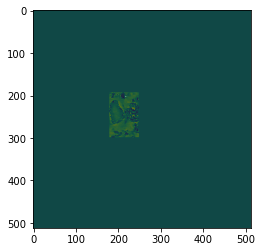

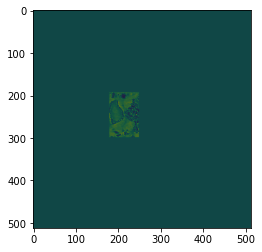

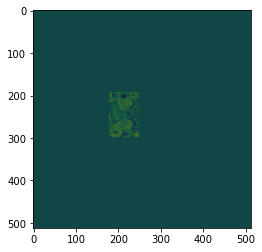

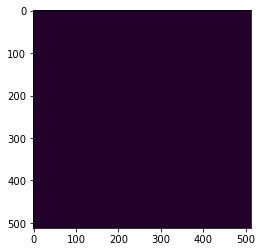

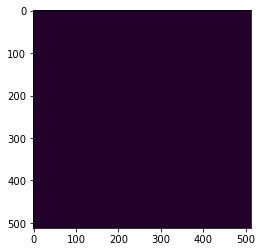

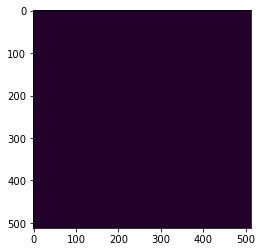

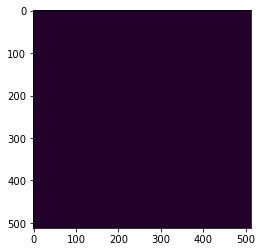

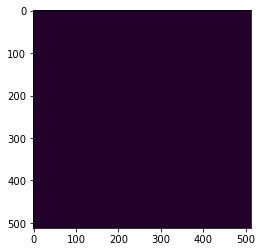

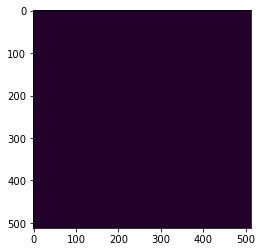

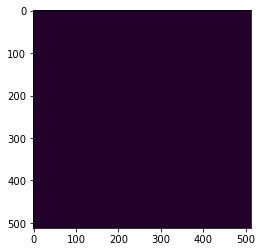

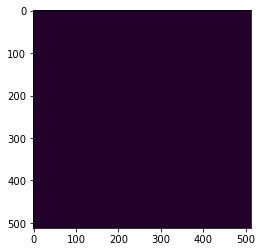

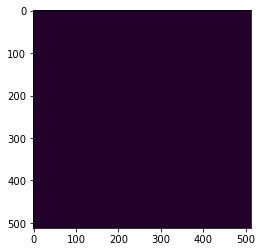

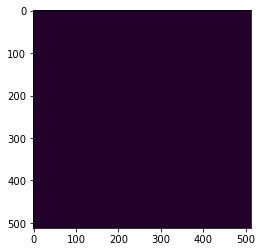

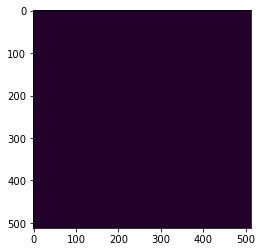

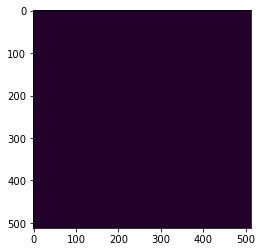

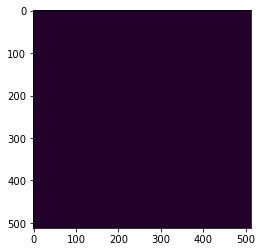

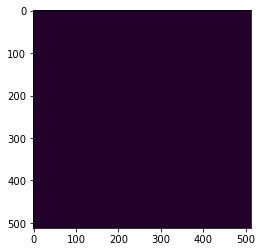

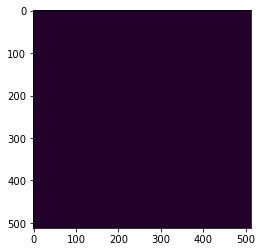

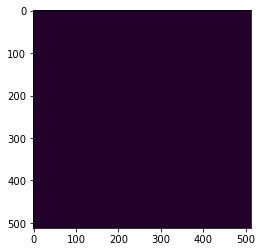

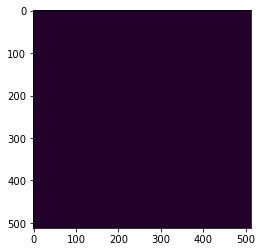

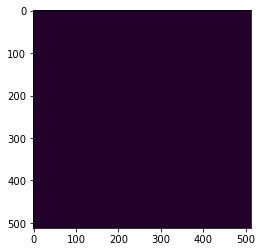

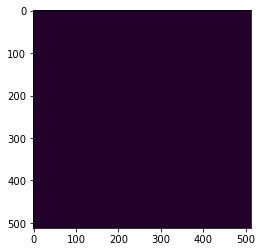

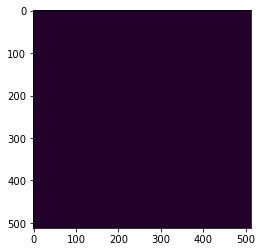

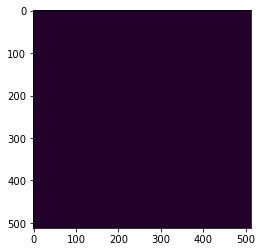

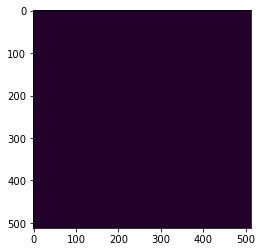

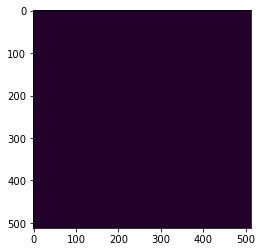

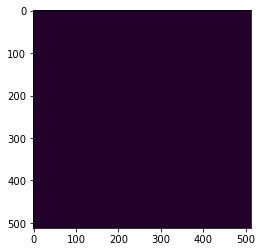

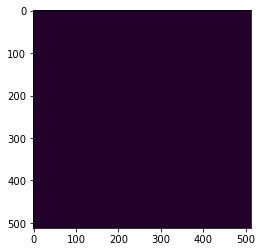

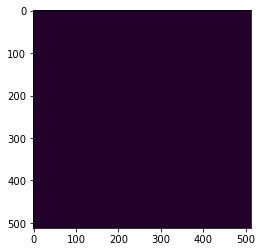

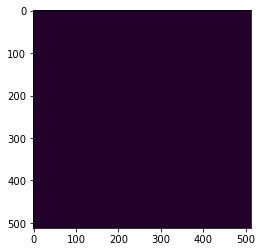

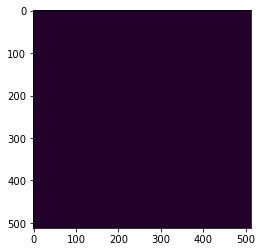

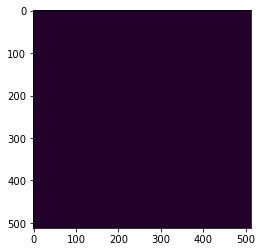

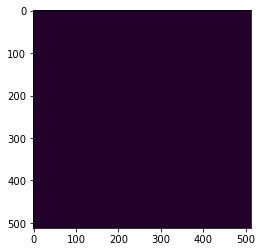

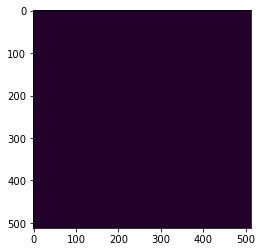

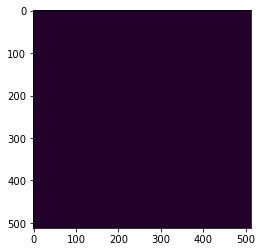

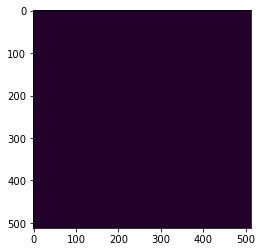

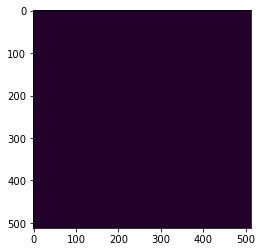

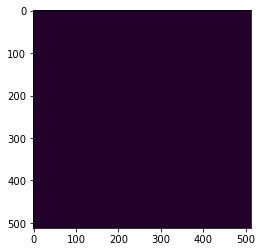

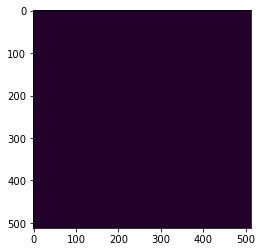

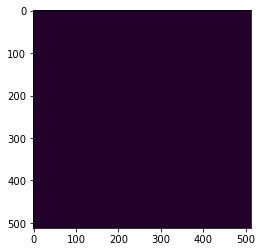

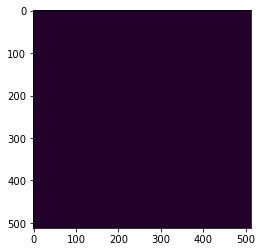

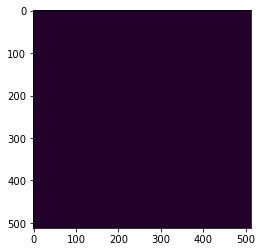

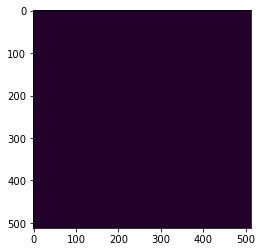

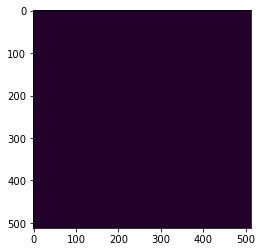

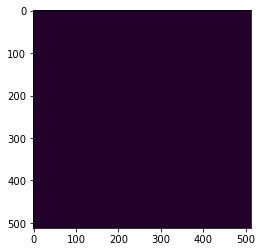

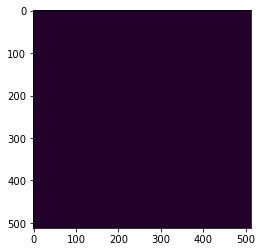

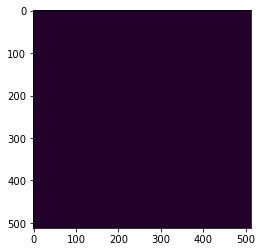

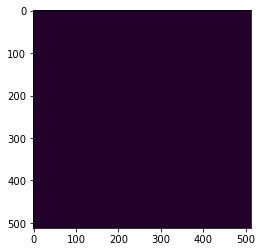

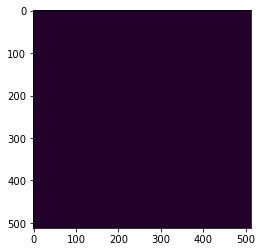

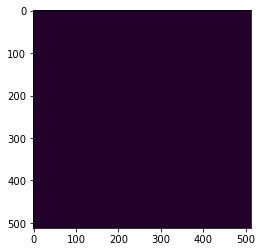

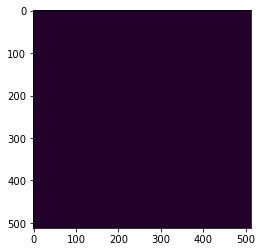

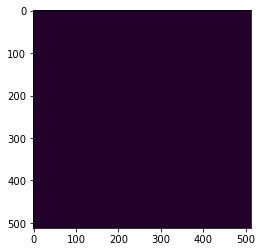

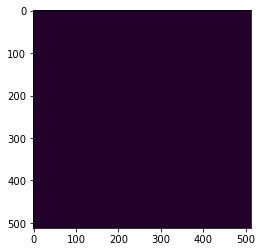

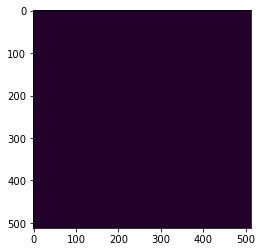

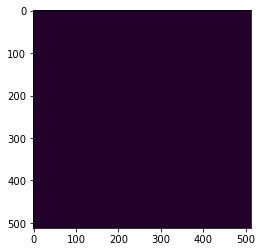

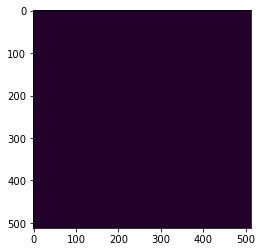

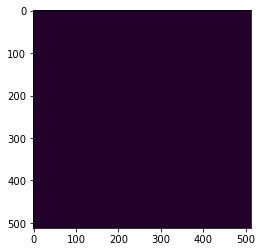

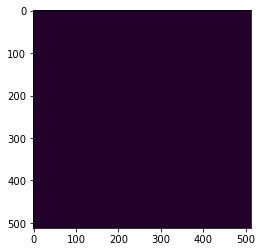

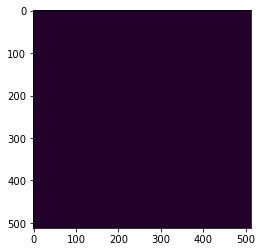

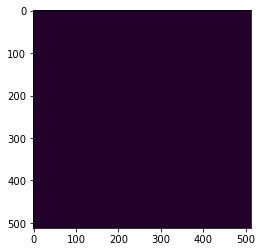

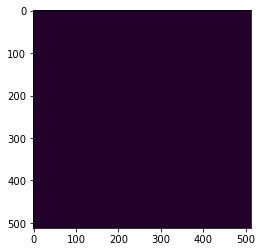

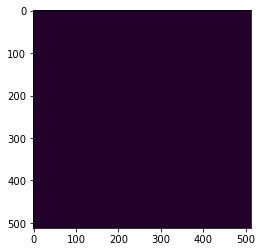

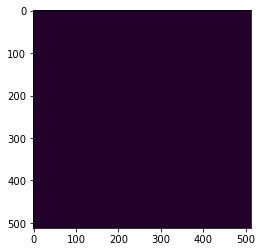

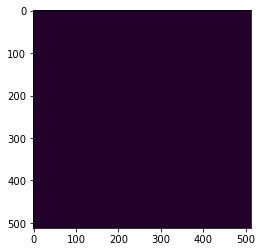

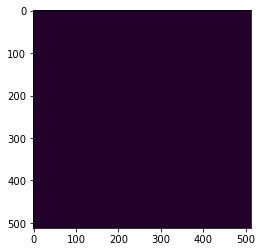

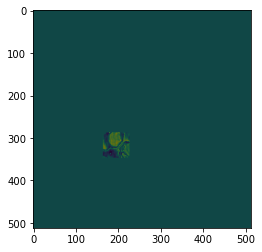

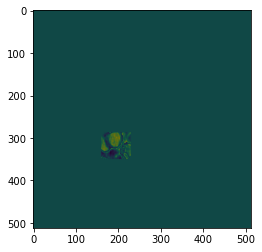

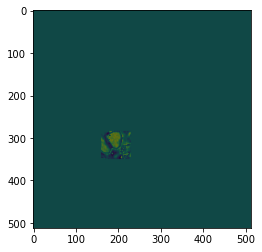

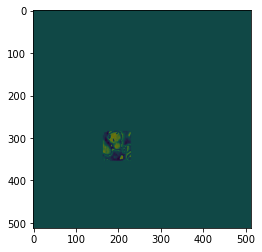

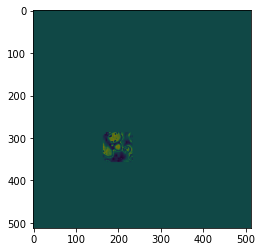

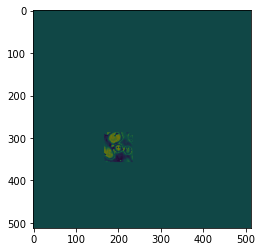

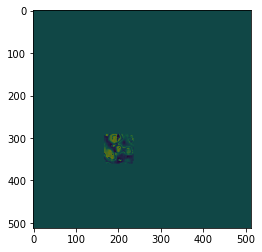

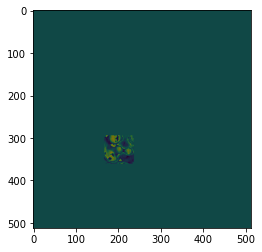

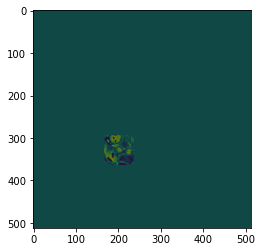

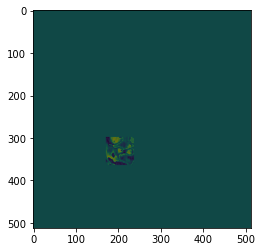

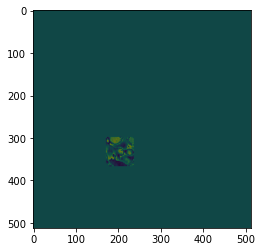

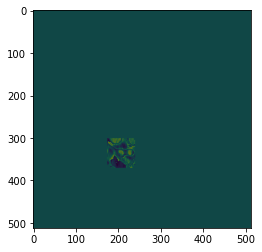

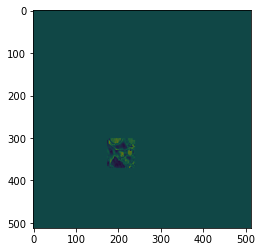

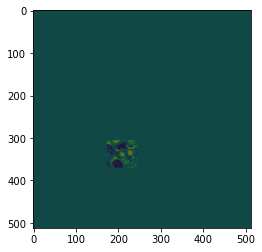

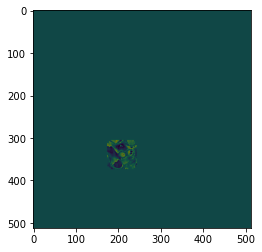

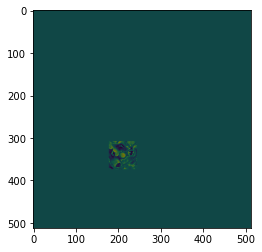

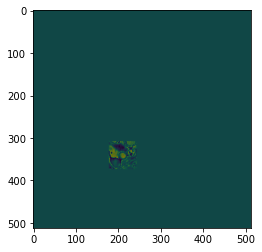

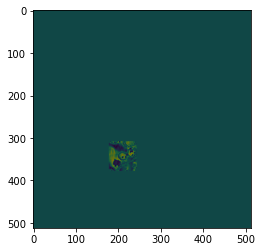

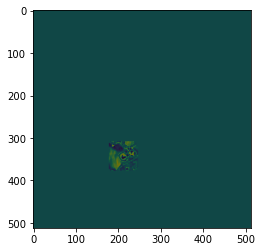

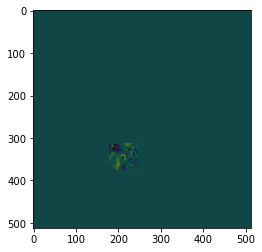

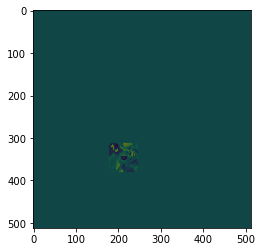

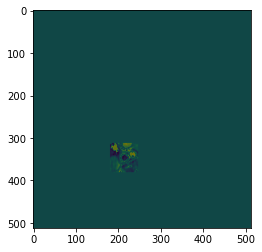

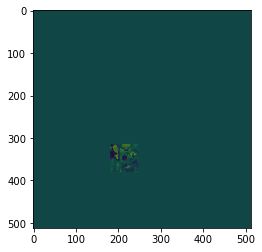

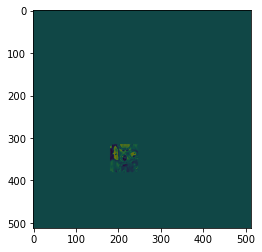

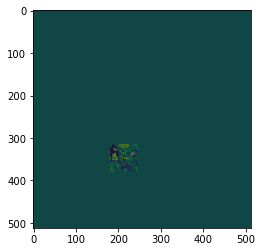

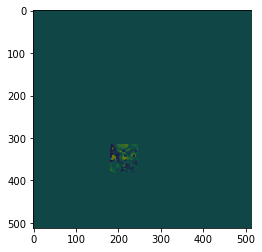

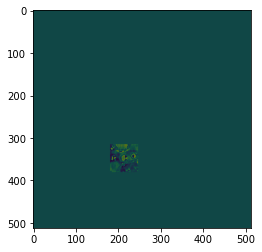

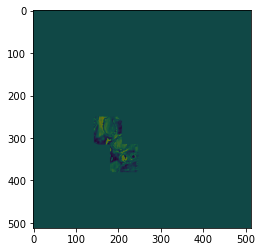

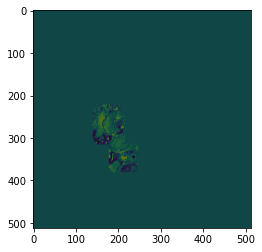

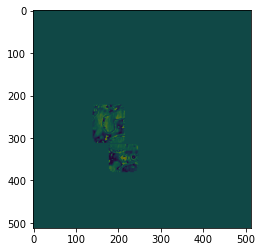

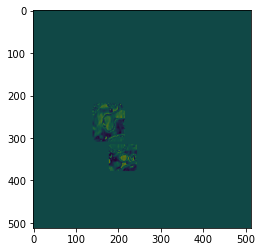

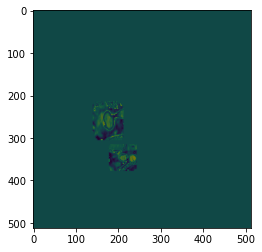

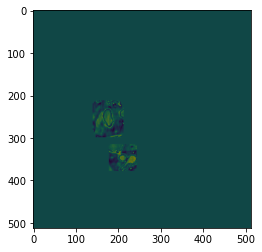

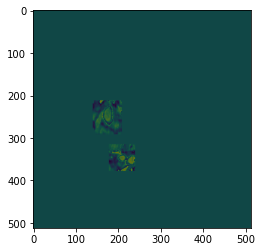

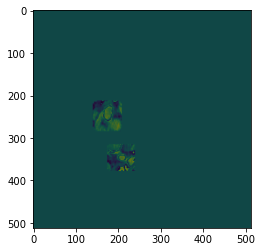

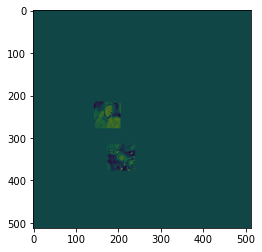

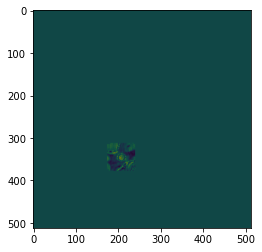

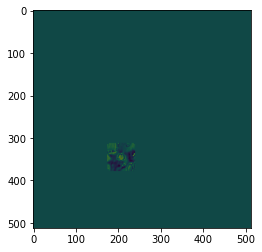

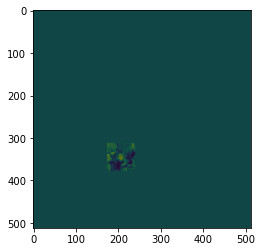

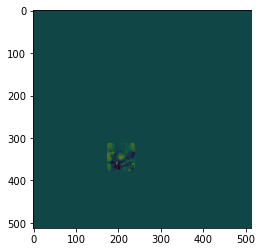

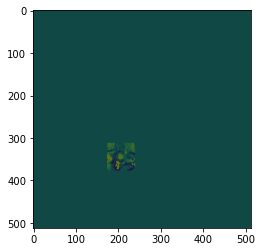

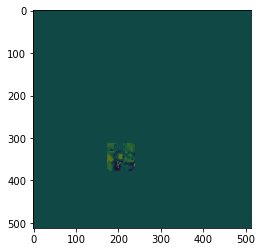

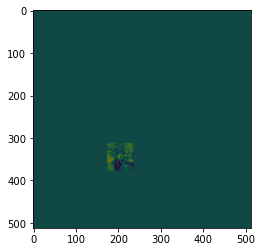

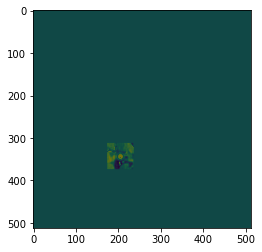

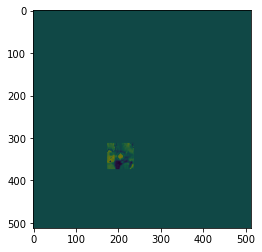

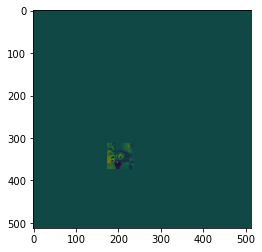

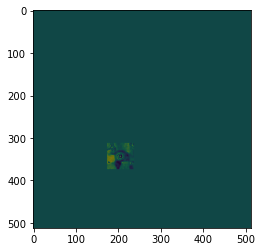

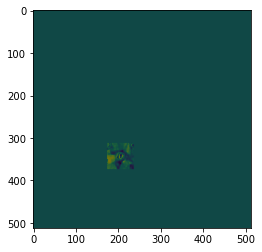

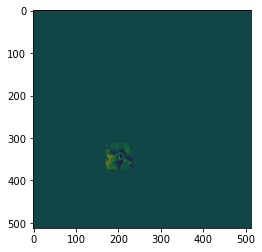

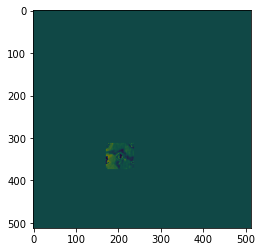

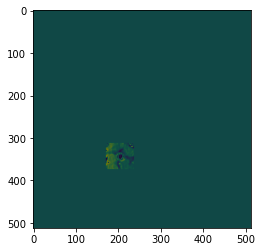

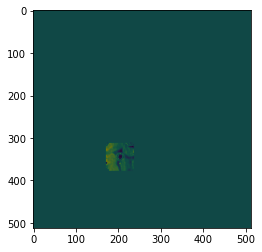

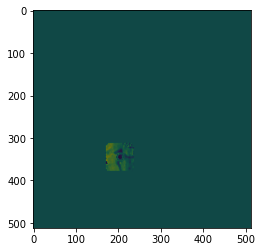

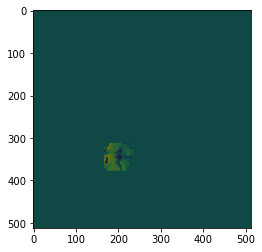

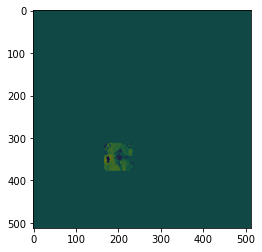

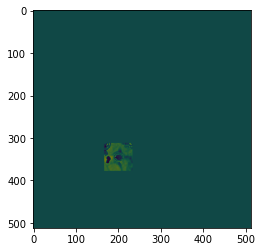

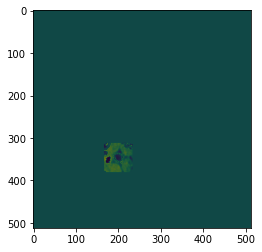

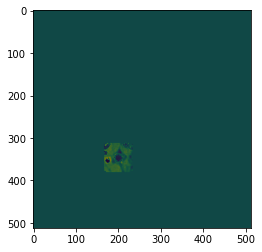

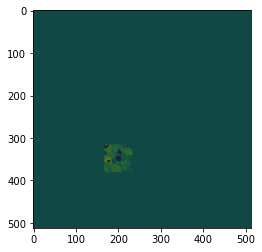

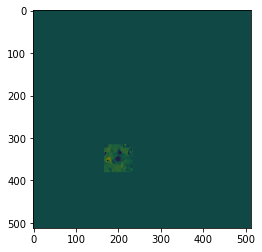

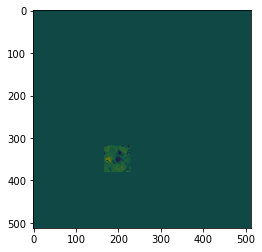

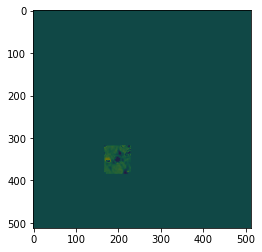

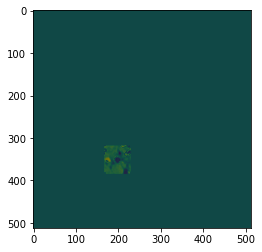

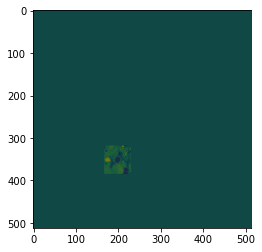

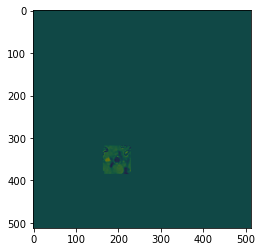

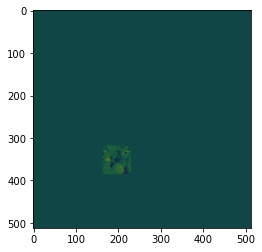

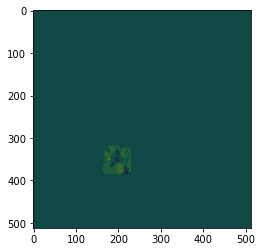

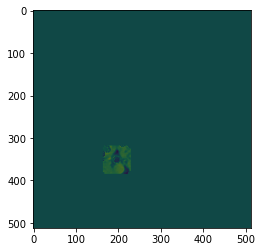

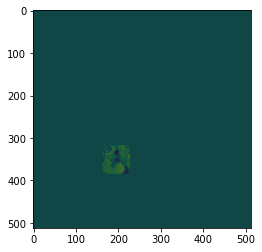

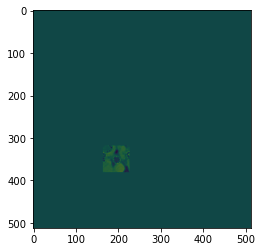

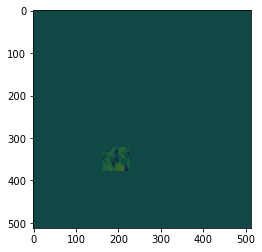

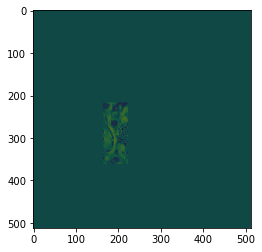

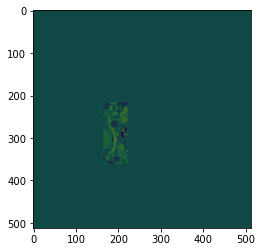

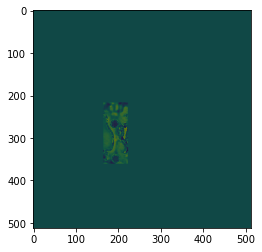

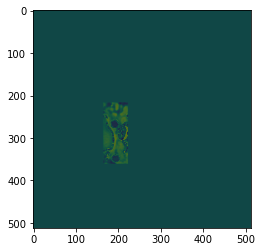

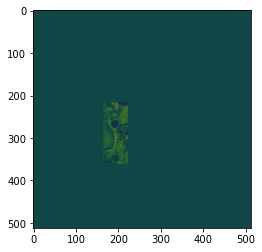

In [29]:
for i in range(600,900):
    plt.imshow(results[i])
    plt.imshow(y_train_array[i], cmap='gray', alpha=0.5)
    #plt.imshow(label[:,:,i], cmap='gray', alpha=0.5)
    plt.show()

In [30]:
binary_masks = []
test_images=[]
image_patient=[]
label_patient=[]
results=[]


for j, t in enumerate(test_id):
    for p, subfolder in enumerate(os.listdir(TS_PATH)):
        if t == int(subfolder):         
            subfolder_path = os.path.join(TS_PATH, str(subfolder))

            if os.path.isdir(subfolder_path):
                left_image_path = os.path.join(subfolder_path, 'common_carotid_artery_left.nii.gz')
                right_image_path = os.path.join(subfolder_path, 'common_carotid_artery_right.nii.gz')
                
                #print(j, X_train[j])
                image, header = nrrd.read(DATAPATH + "/" + X_test[j])
                label, header = nrrd.read(DATAPATH + "/" + y_test[j])
                
                #bbox_plaque = mh.bbox(label)
                
                for i in range(image.shape[2]):
                    imgs = image[:,:,i]
                    image_patient.append(imgs)
                X_test_array = np.array(image_patient)
                
                for i in range(label.shape[2]):
                    labl = np.where(label[:,:,i] != 0, True, False)
                    label_patient.append(labl)
                y_test_array = np.array(label_patient)
                    
                if os.path.exists(left_image_path) and os.path.exists(right_image_path):
                    left_image = nib.load(left_image_path).get_fdata()
                    right_image = nib.load(right_image_path).get_fdata()

                    combined = left_image + right_image
                    bbox_combined = mh.bbox(combined)
    

                    for i in range(combined.shape[2]):
                        img = combined[:, :, i]
                        T_otsu = threshold_otsu(img)
                        img = img > T_otsu
                        es = np.ones((50, 50), bool)
                        dilate_img = mh.morph.dilate(img,es)
                        bbox = mh.bbox(dilate_img)
                        

                        if i >= bbox_combined[4] and i <= bbox_combined[5]+51:
                            if np.all(bbox == 0):
                                bbox = [bbox_combined[0],
                                        bbox_combined[1],
                                        bbox_combined[2],
                                        bbox_combined[3]]
                                dilate_img[bbox[0]:bbox[1], bbox[2]:bbox[3]] = 1

                        test_images.append(dilate_img)

In [31]:
for i in range(len(test_images)):
    binary = (test_images[i] > 0).astype(np.uint8) * 255
    binary_masks.append(binary)

In [32]:
result_test=[]
for i in range(len(X_test_array)):
    result = X_test_array[i] * binary_masks[i]
    result_test.append(result)

In [33]:
len(X_test_array), len(y_test_array)

(3607, 3607)

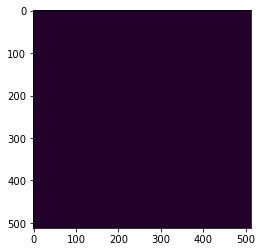

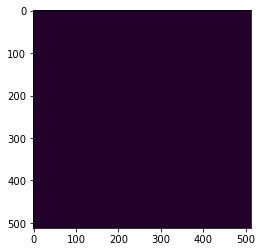

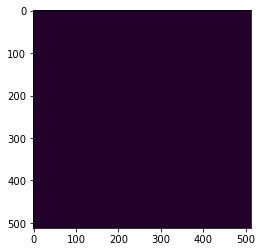

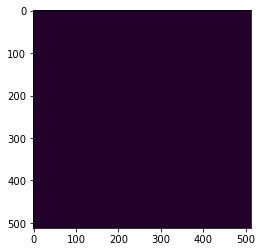

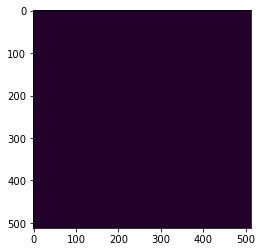

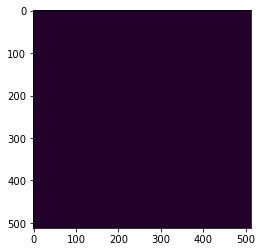

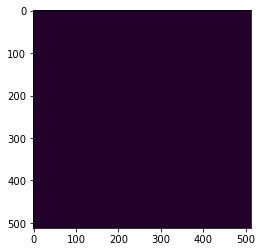

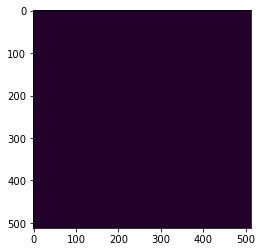

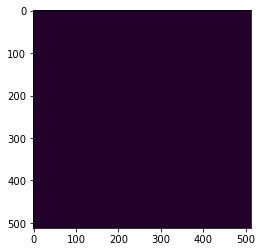

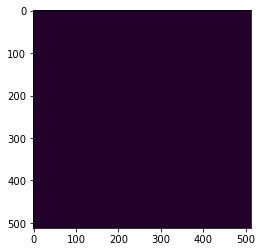

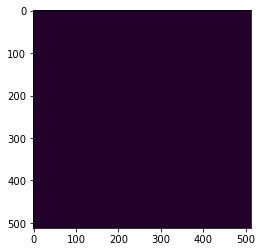

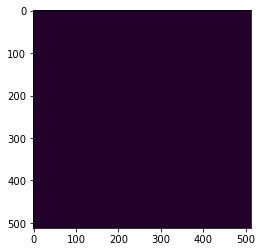

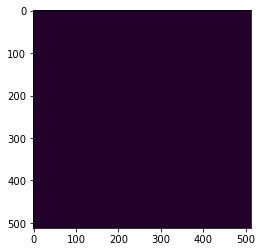

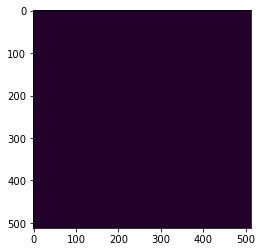

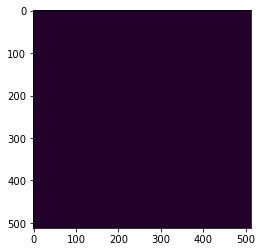

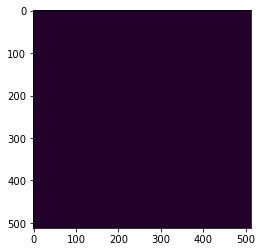

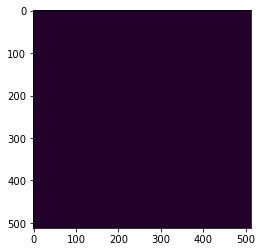

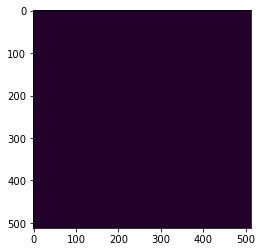

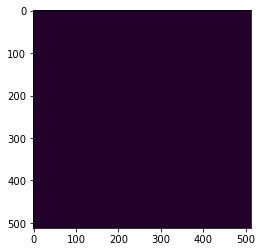

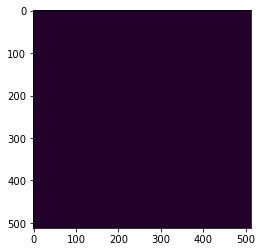

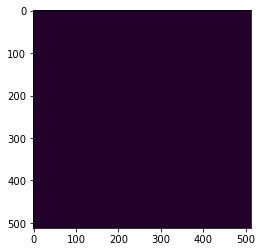

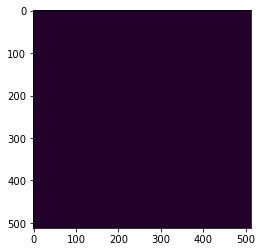

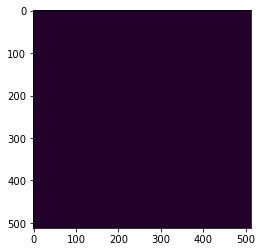

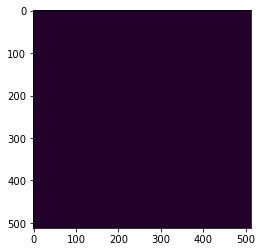

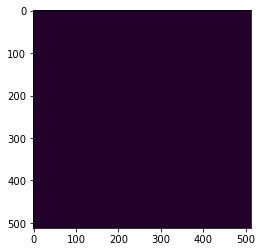

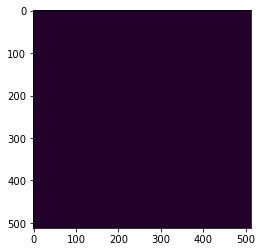

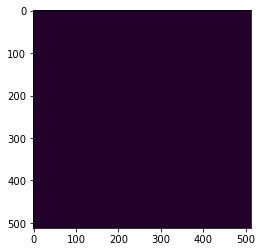

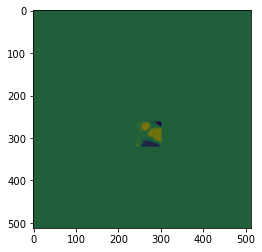

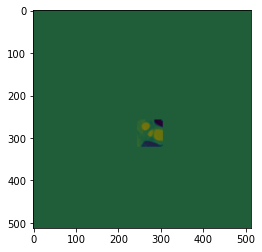

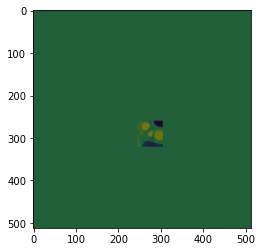

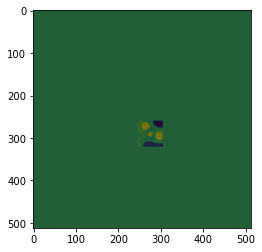

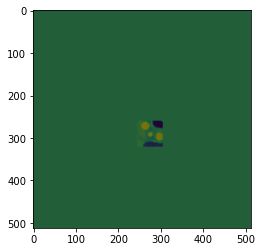

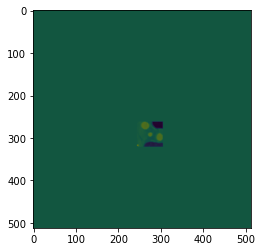

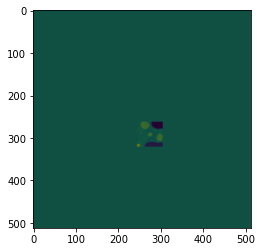

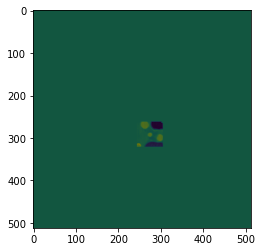

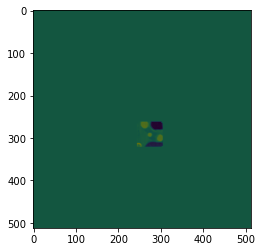

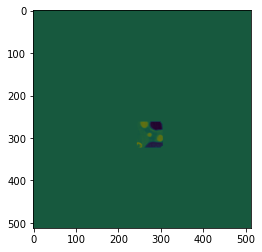

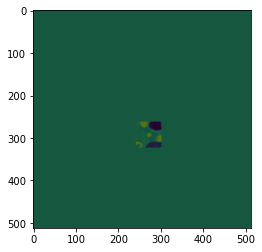

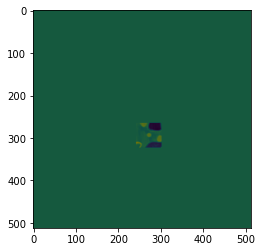

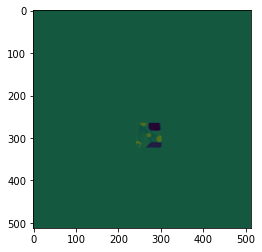

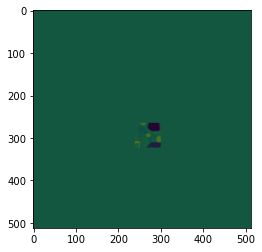

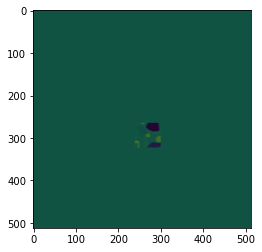

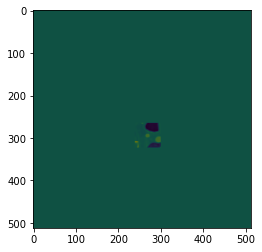

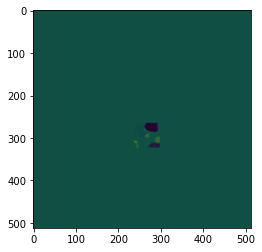

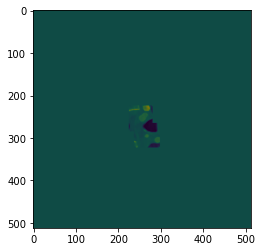

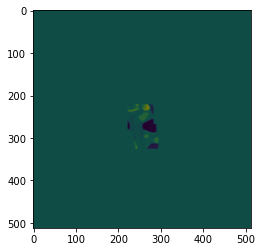

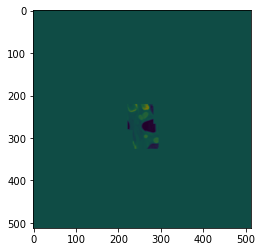

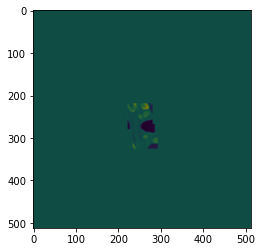

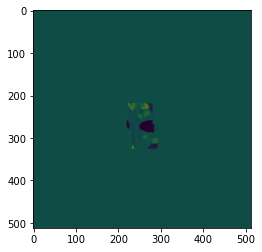

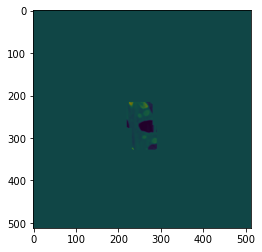

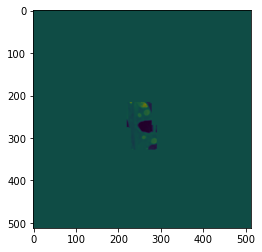

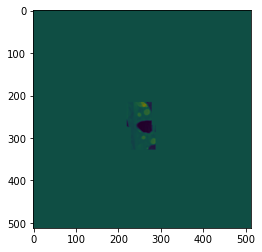

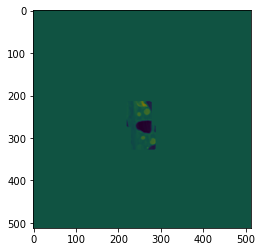

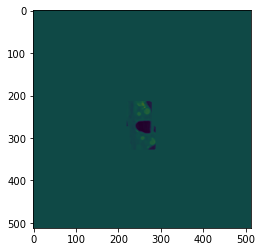

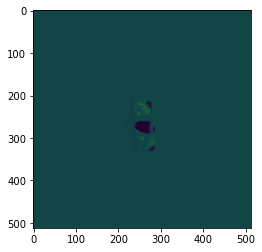

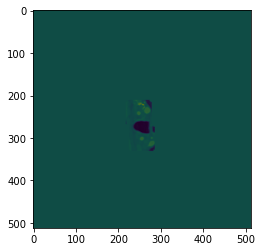

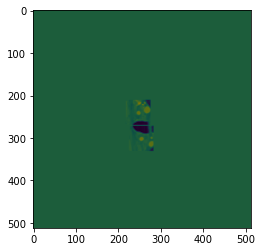

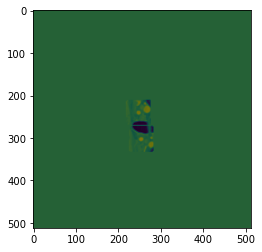

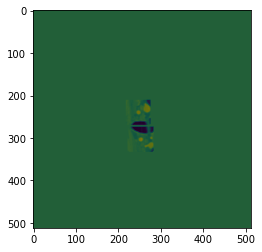

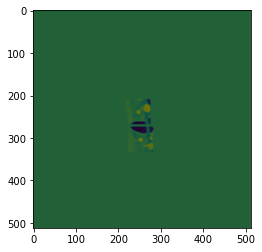

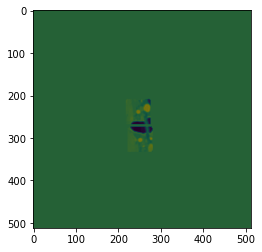

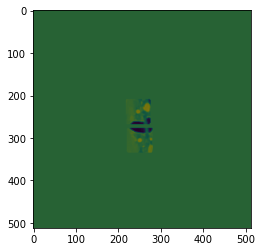

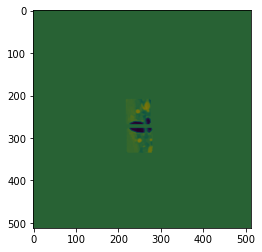

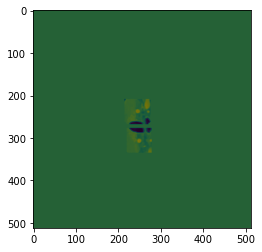

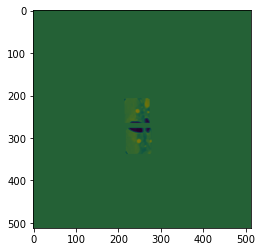

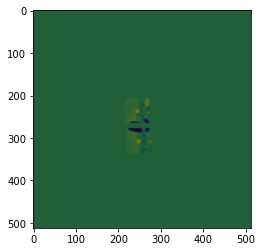

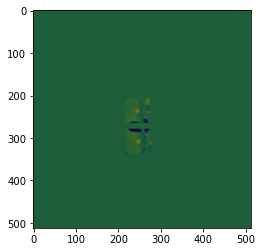

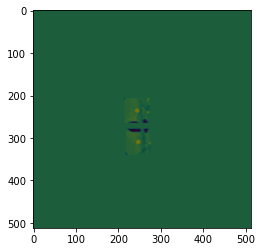

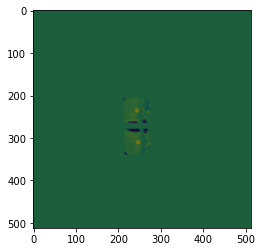

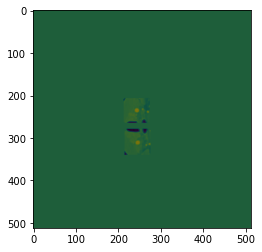

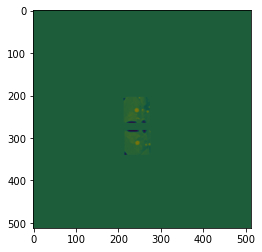

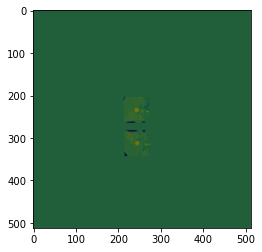

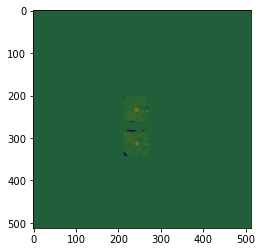

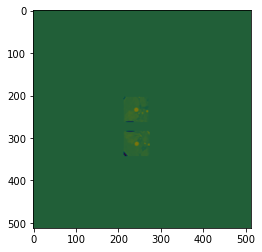

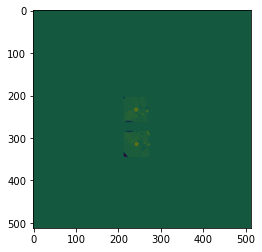

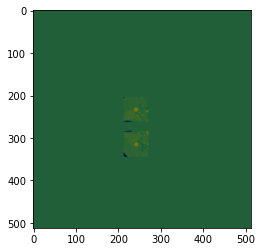

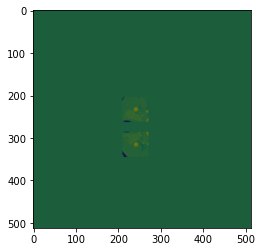

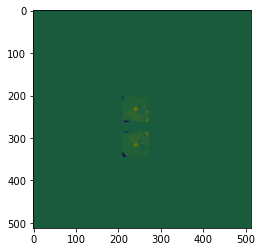

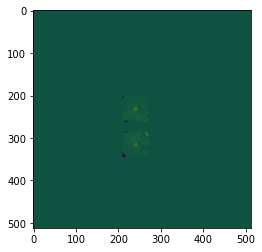

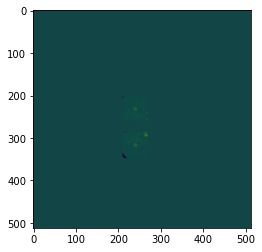

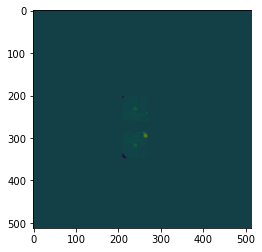

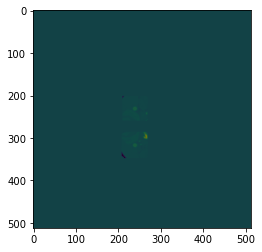

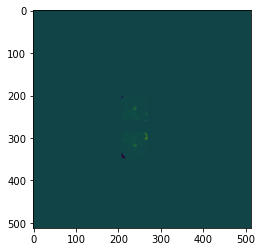

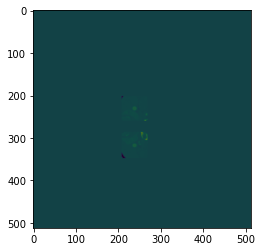

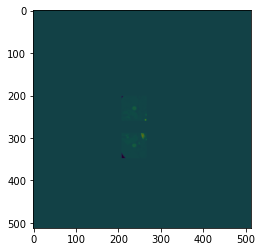

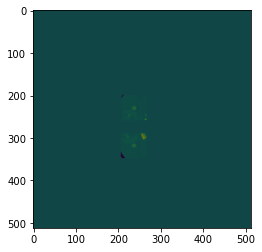

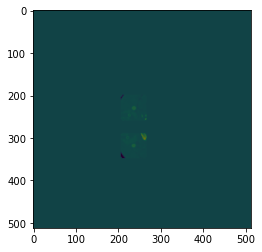

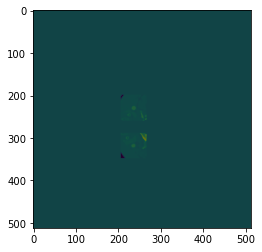

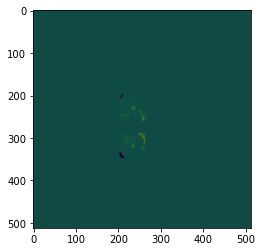

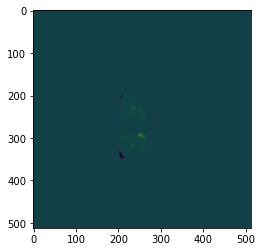

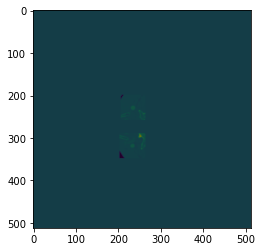

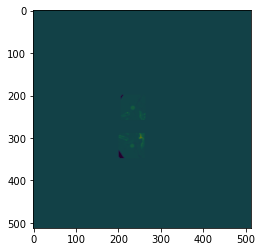

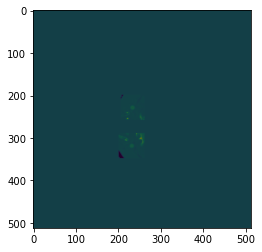

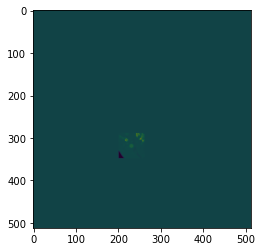

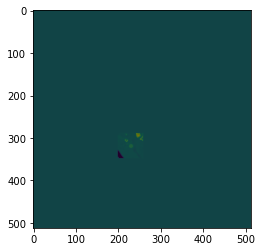

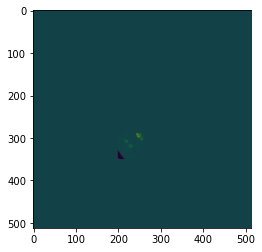

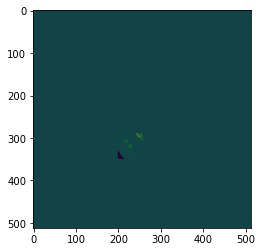

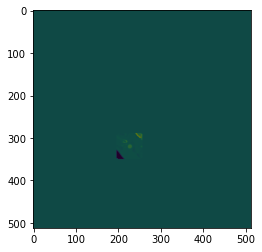

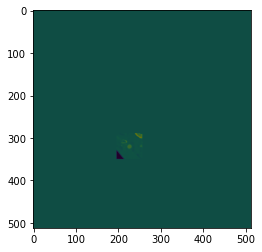

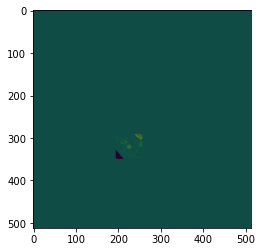

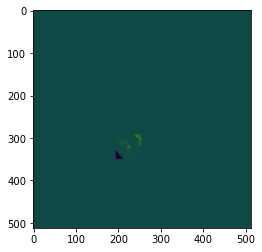

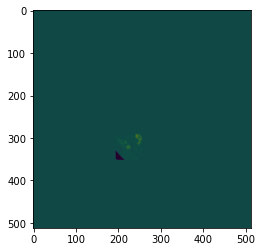

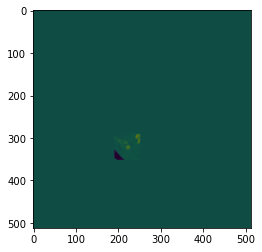

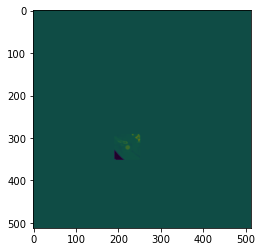

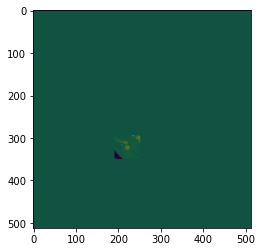

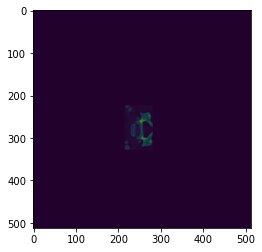

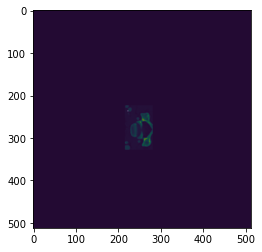

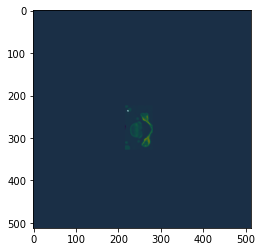

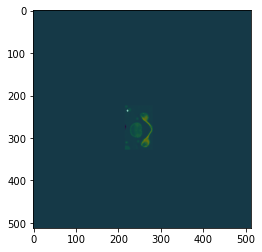

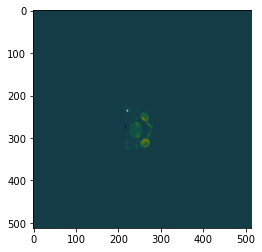

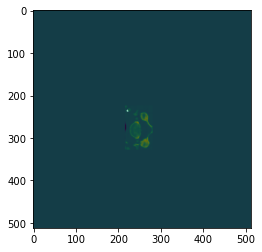

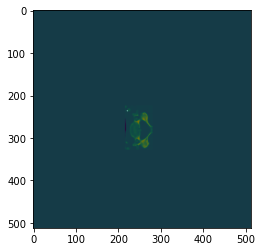

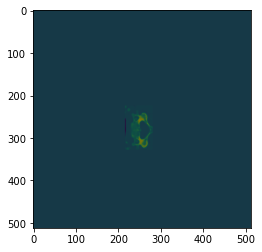

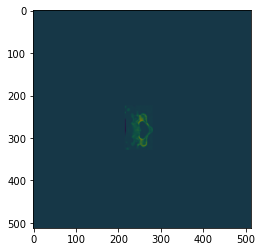

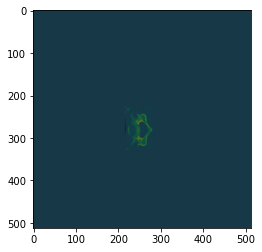

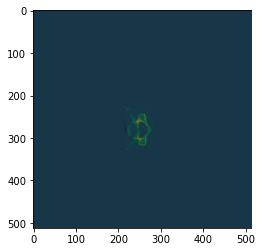

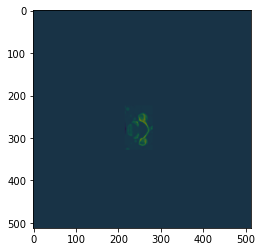

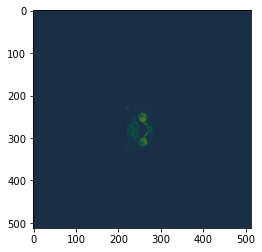

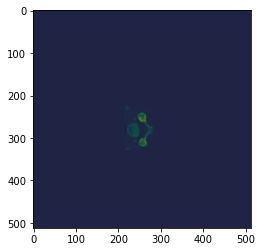

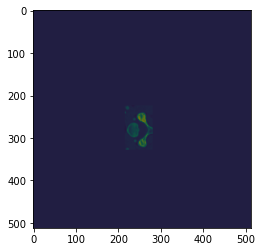

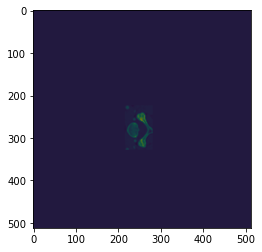

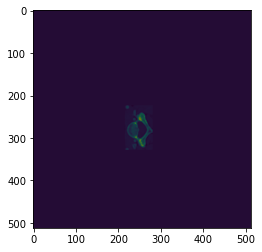

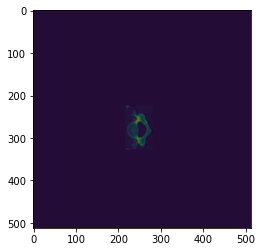

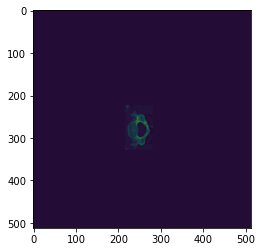

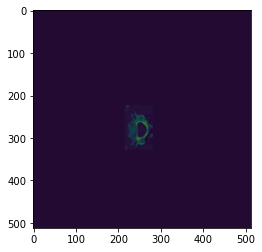

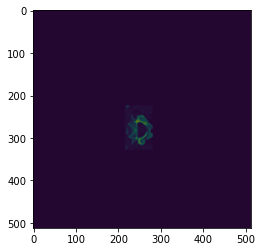

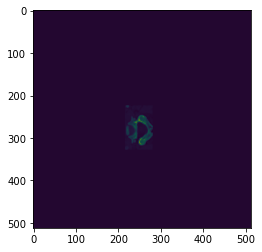

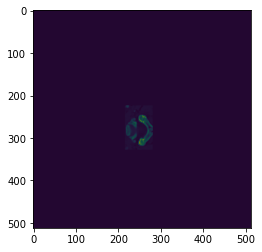

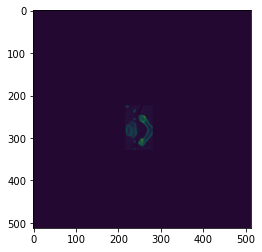

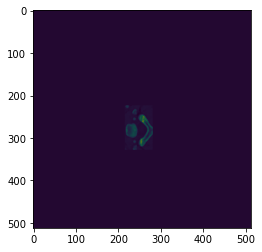

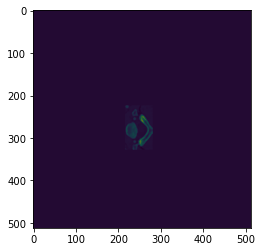

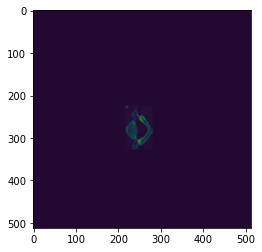

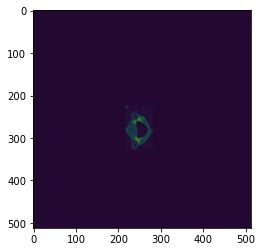

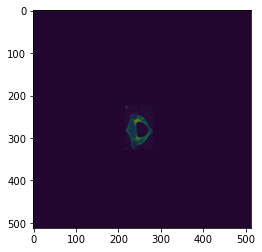

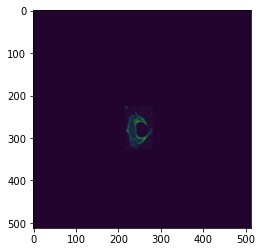

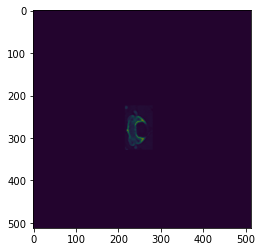

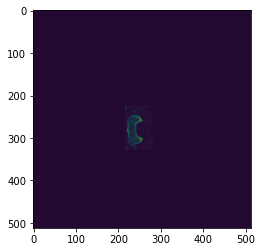

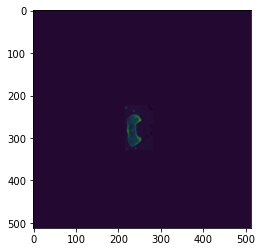

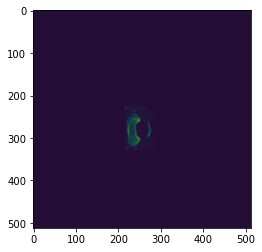

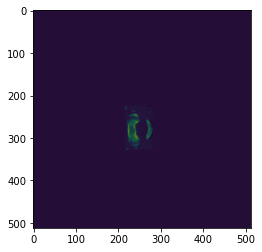

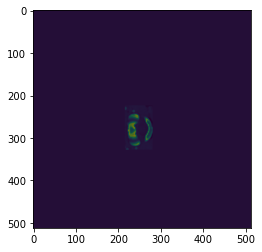

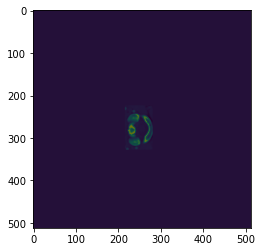

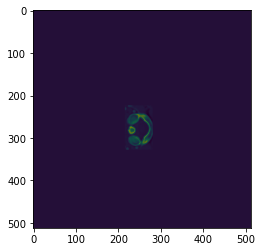

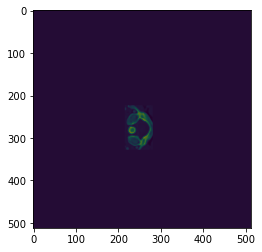

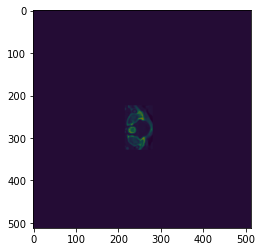

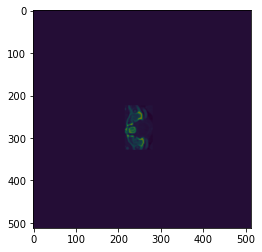

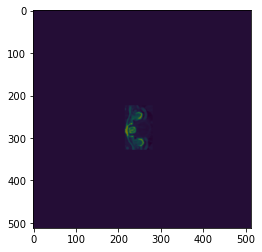

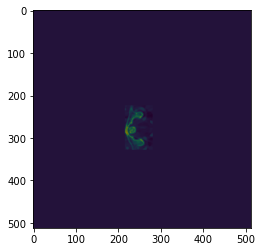

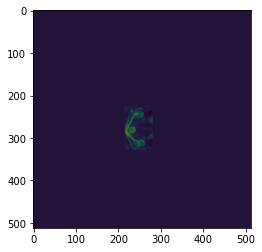

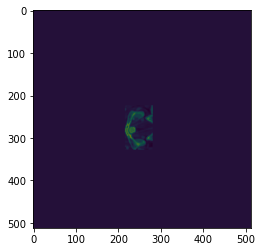

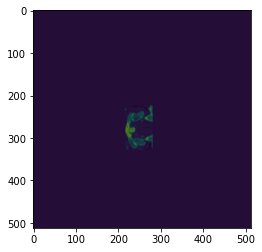

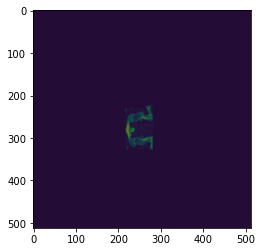

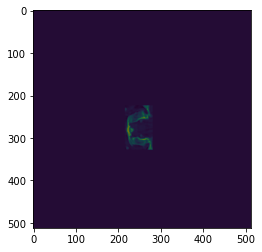

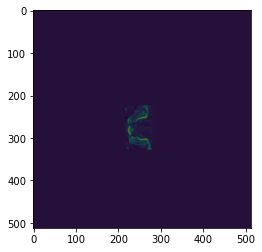

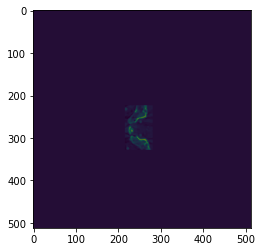

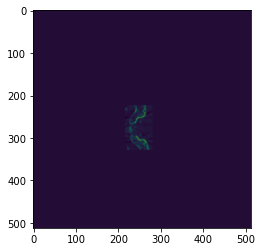

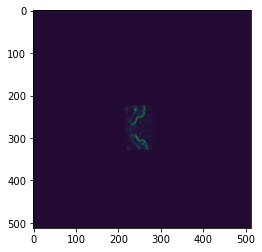

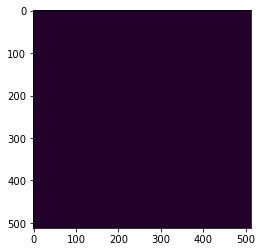

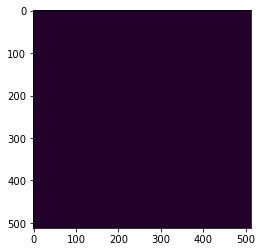

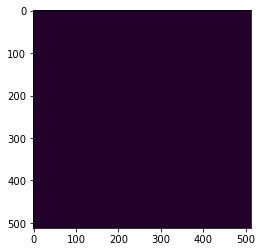

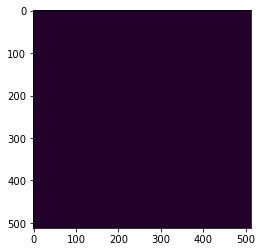

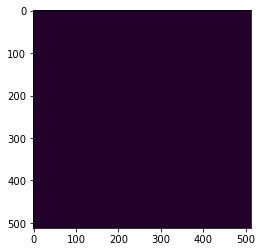

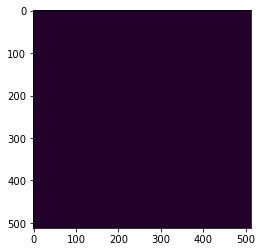

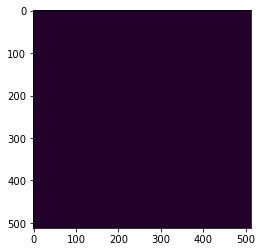

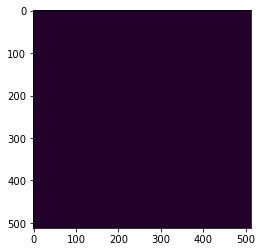

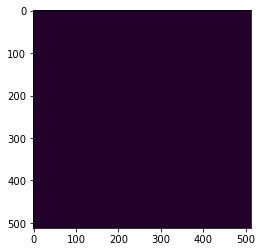

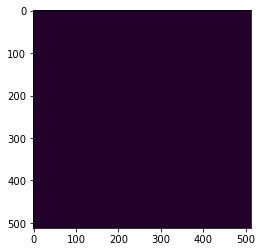

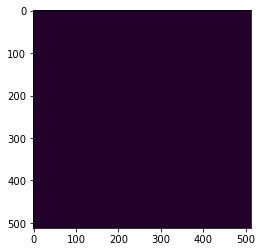

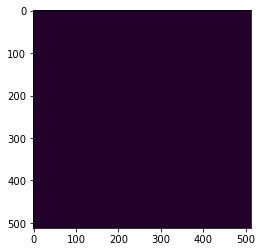

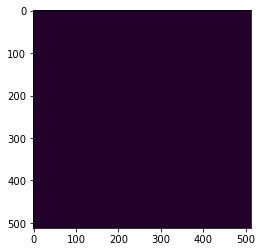

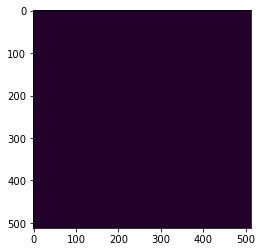

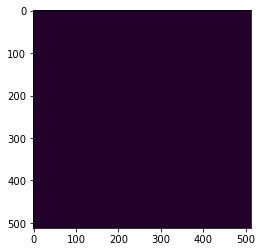

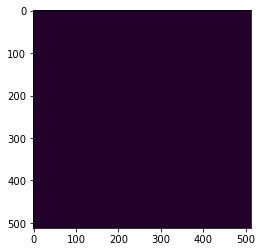

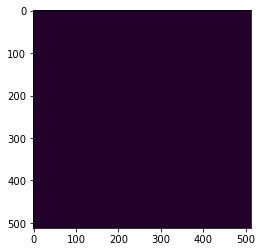

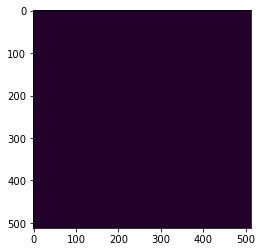

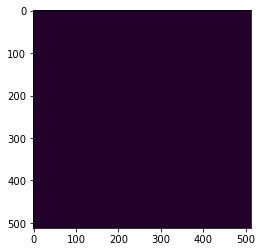

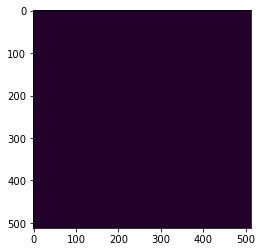

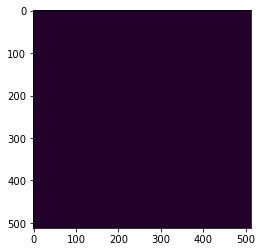

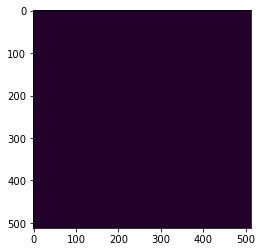

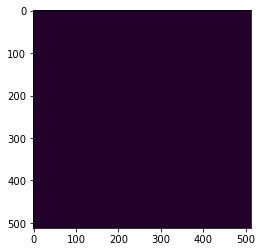

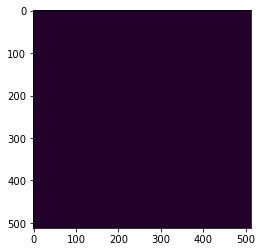

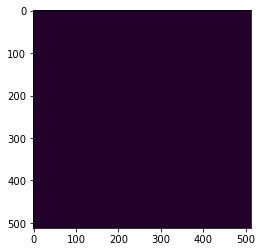

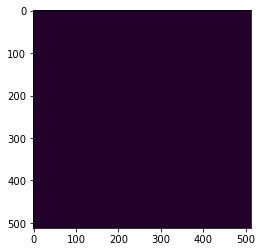

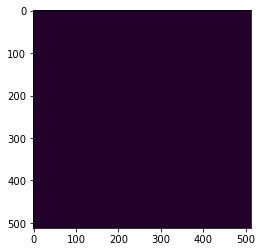

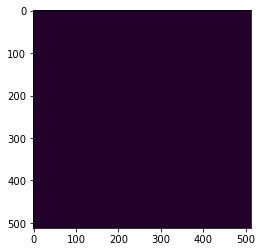

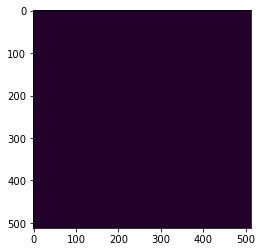

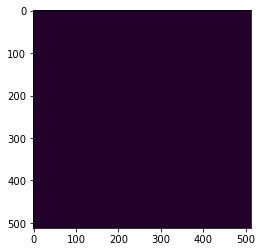

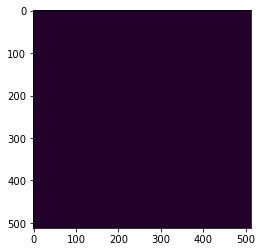

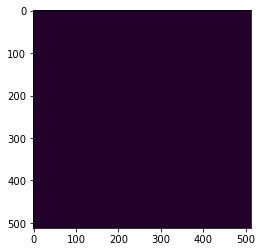

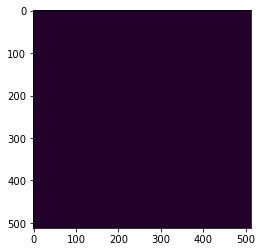

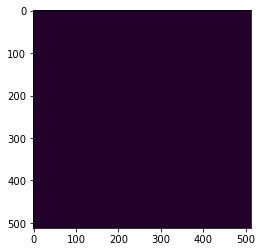

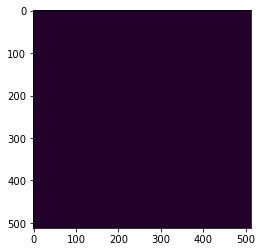

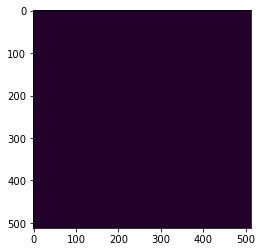

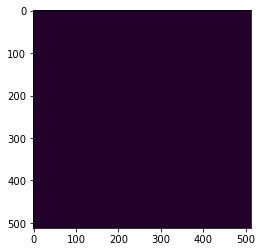

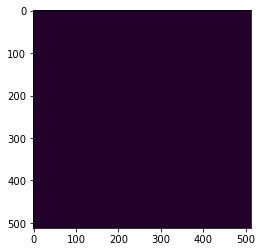

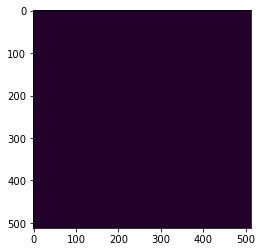

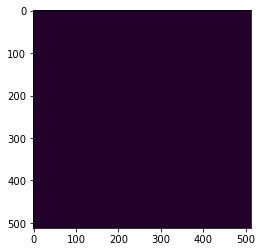

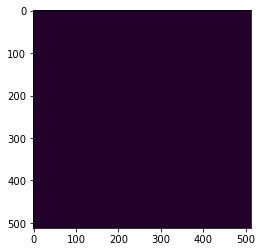

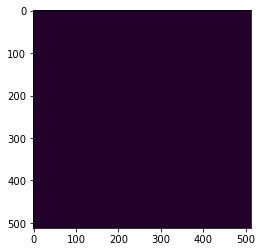

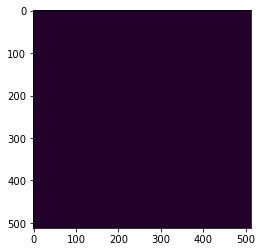

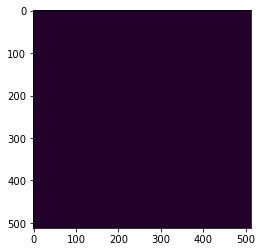

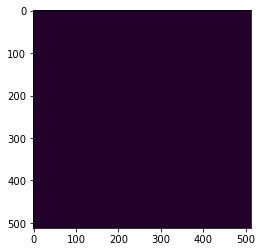

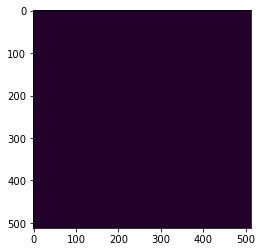

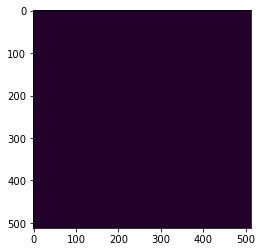

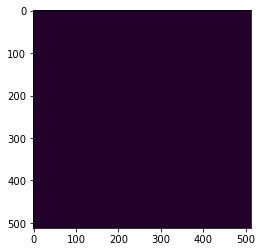

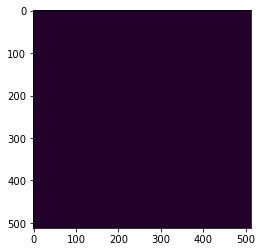

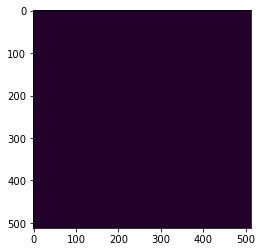

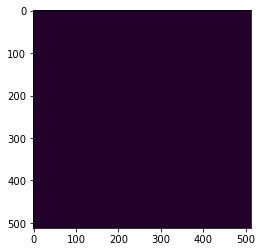

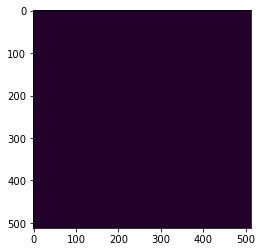

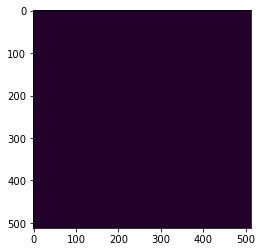

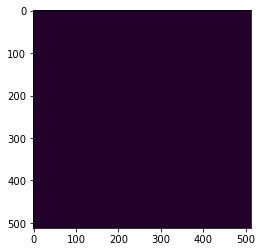

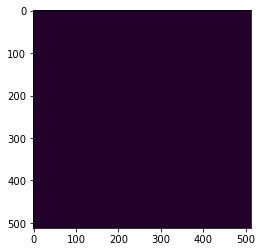

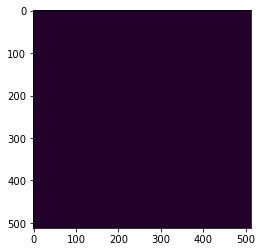

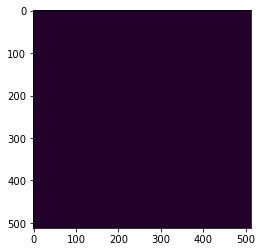

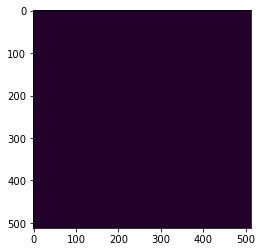

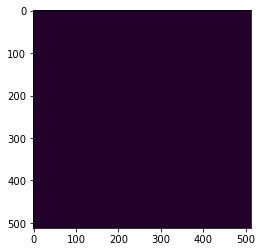

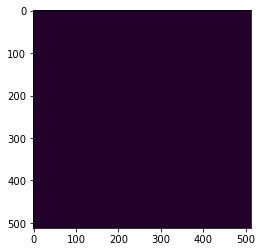

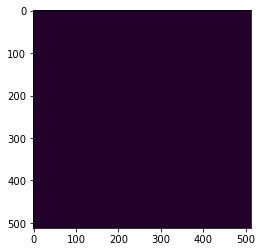

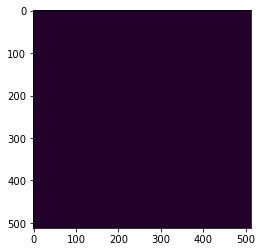

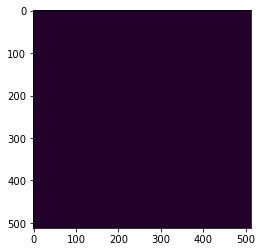

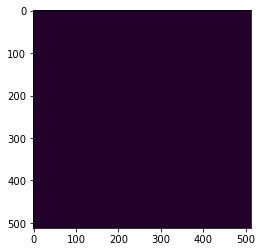

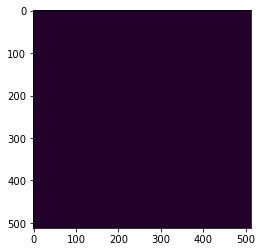

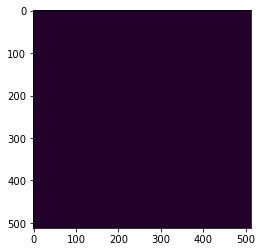

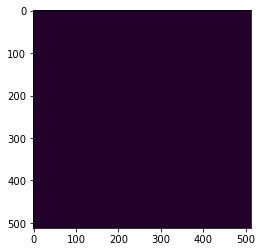

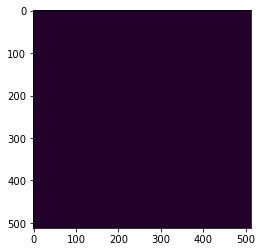

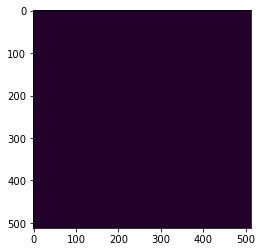

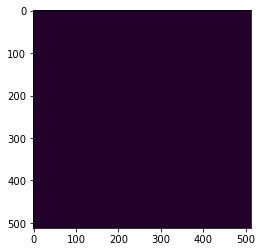

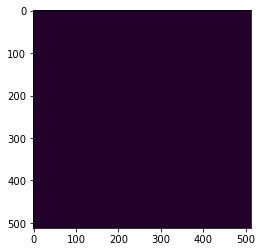

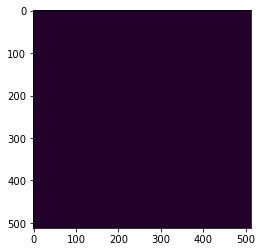

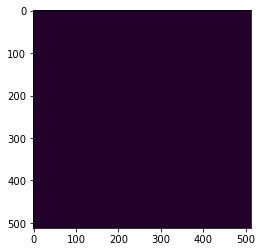

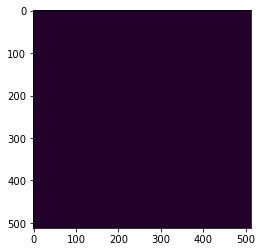

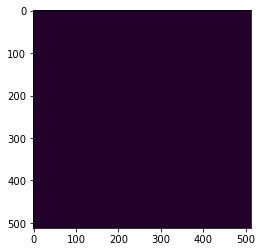

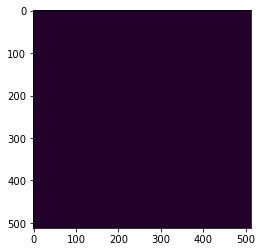

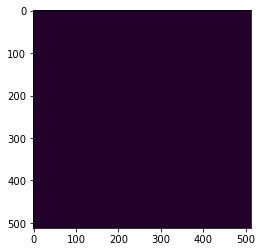

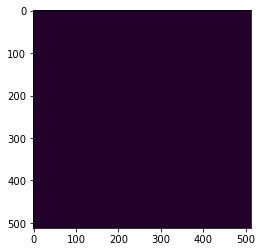

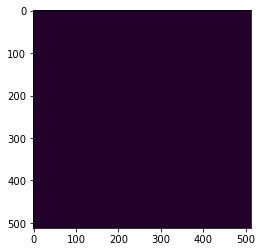

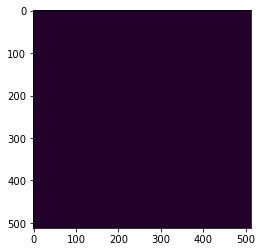

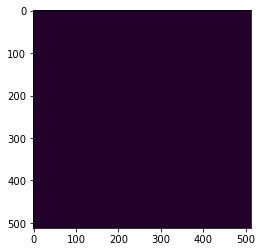

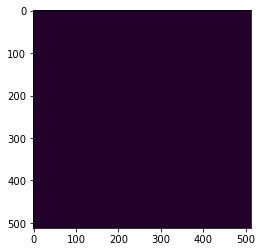

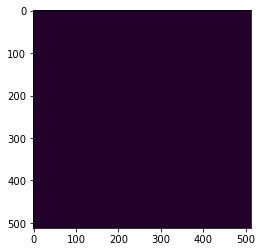

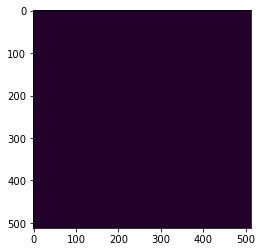

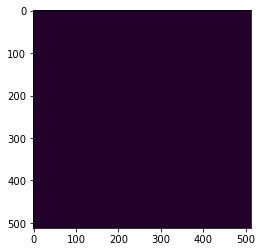

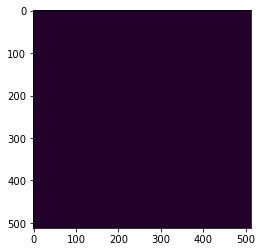

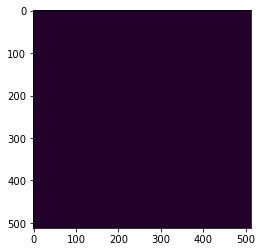

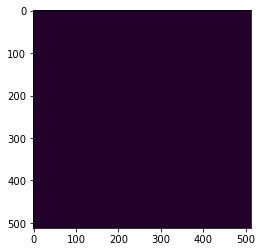

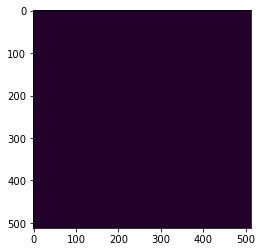

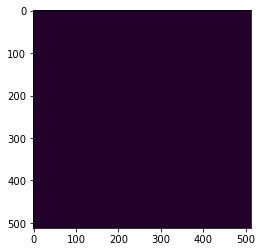

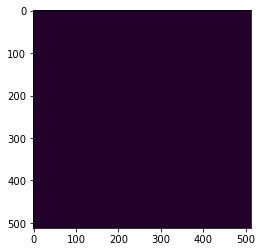

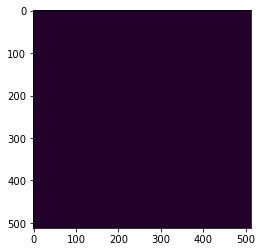

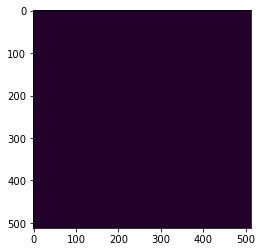

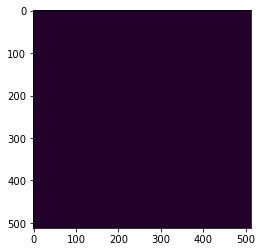

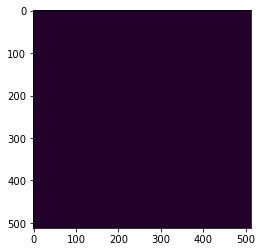

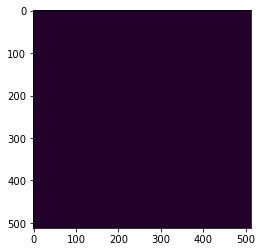

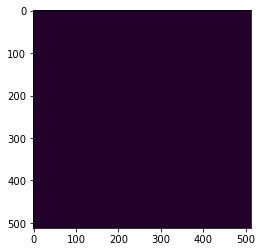

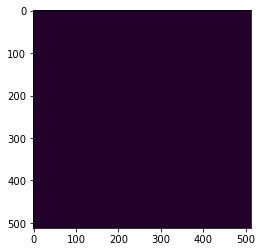

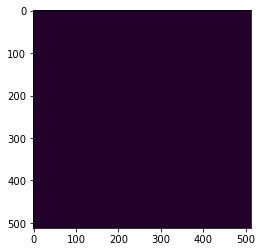

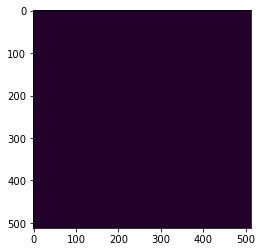

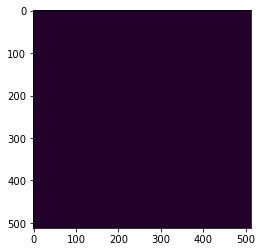

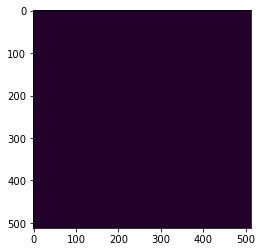

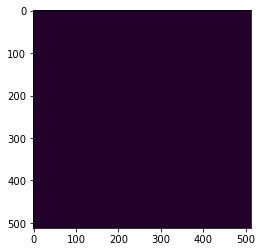

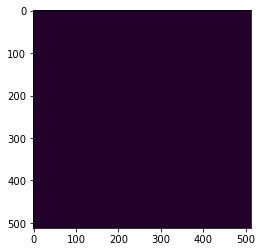

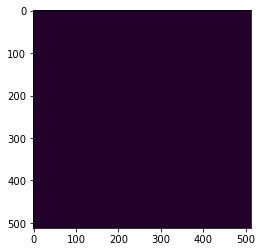

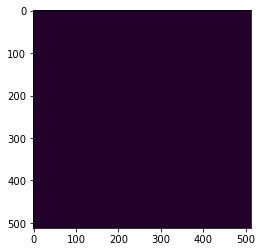

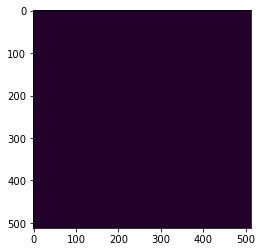

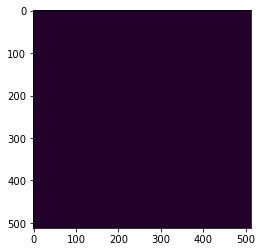

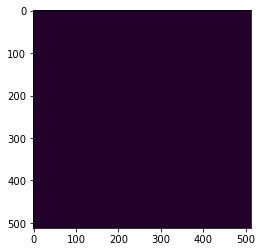

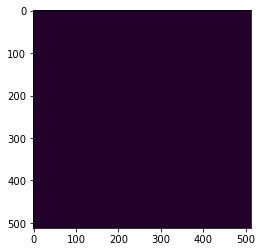

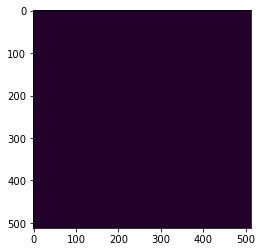

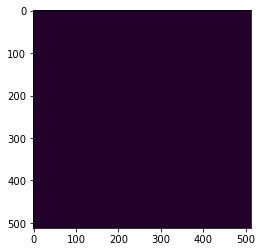

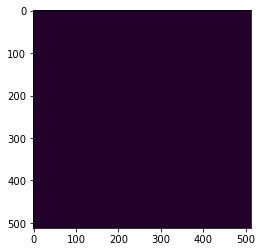

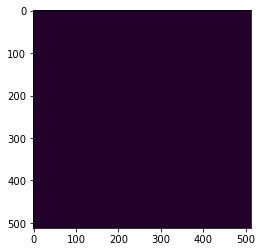

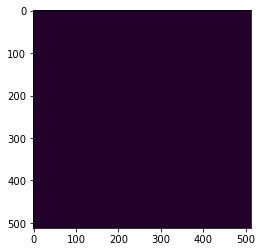

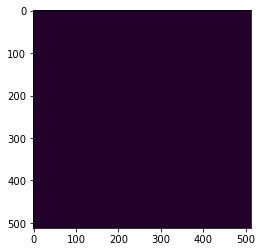

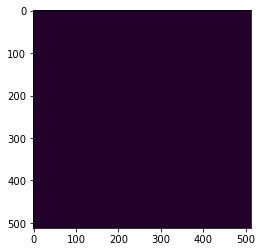

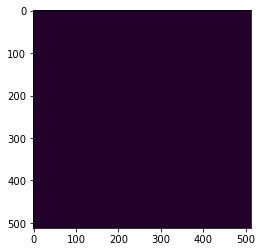

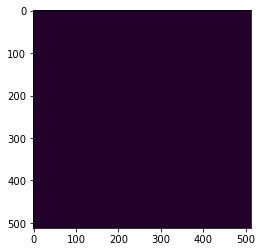

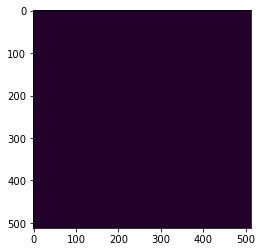

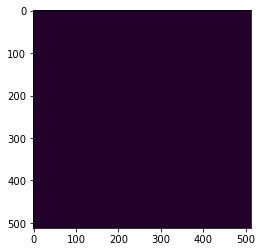

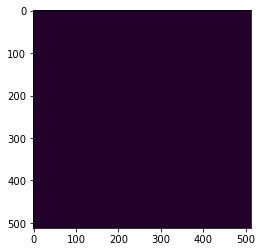

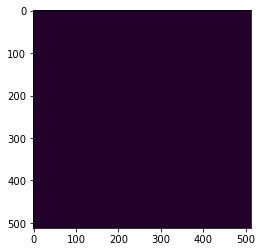

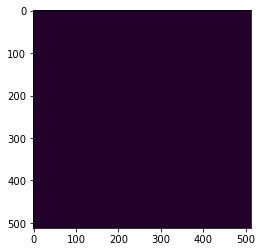

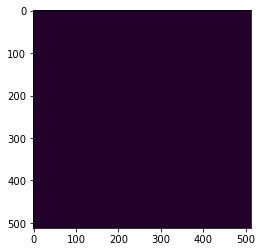

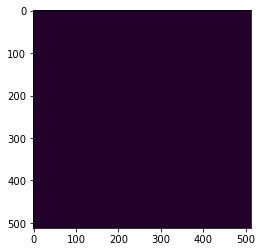

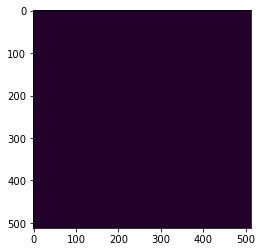

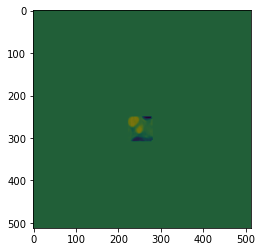

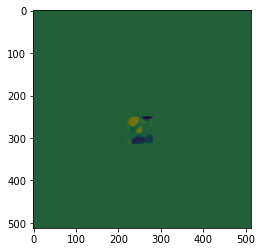

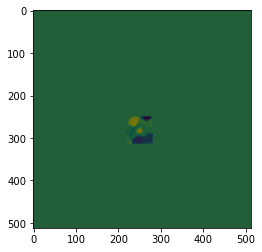

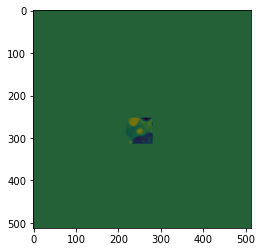

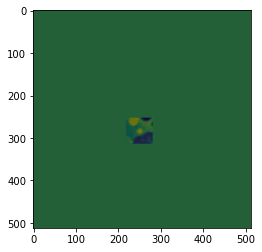

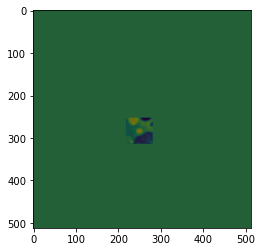

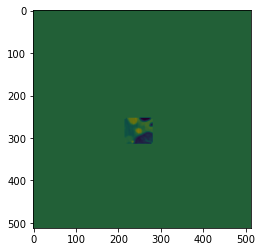

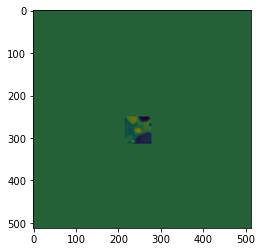

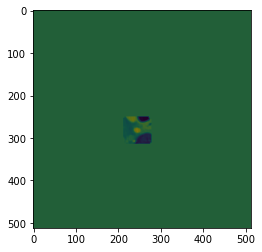

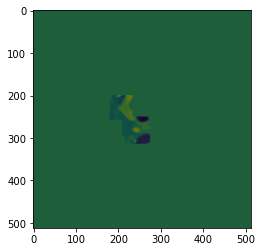

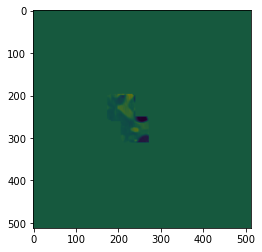

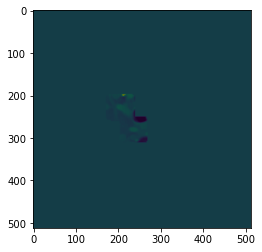

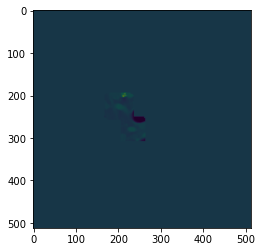

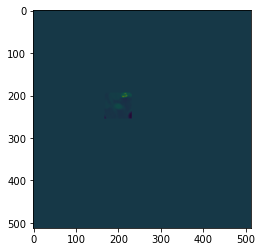

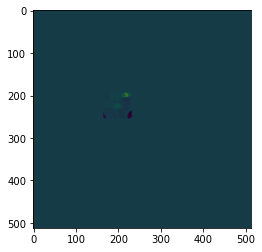

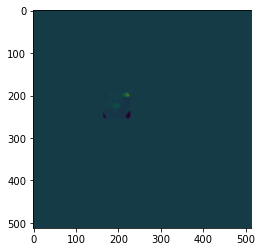

In [34]:
for i in range(300):
    plt.imshow(result_test[i])
    plt.imshow(y_test_array[i], cmap='gray', alpha=0.5)
    #plt.imshow(label[:,:,i], cmap='gray', alpha=0.5)
    plt.show()

In [35]:
X_test_array = X_test_array.astype(np.float64)
y_test_array = y_test_array.astype(np.float64)

In [36]:
X_train_array = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1],X_train_array.shape[2], 1)
y_train_array = y_train_array.reshape(y_train_array.shape[0], y_train_array.shape[1],y_train_array.shape[2], 1)
X_test_array = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1],X_test_array.shape[2], 1)
y_test_array = y_test_array.reshape(y_test_array.shape[0], y_test_array.shape[1],y_test_array.shape[2], 1)

In [37]:
X_train_set = X_train_array[:10834]
y_train_set = y_train_array[:10834]
X_val = X_train_array[10834:]
y_val = y_train_array[10834:]

In [38]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2023-12-08 15:45:09.734014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-12-08 15:45:09.736536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-12-08 15:45:09.746430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2023-12-08 15:45:09.749364: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-12-08 15:45:09.752108: I tensorflow/core

In [ ]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=100)

Epoch 1/100
338/338 [==============================] - 338s 1s/step - loss: 7.6845e-04 - iou: 0.0052 - iou_thresholded: 0.0373 - val_loss: 5.0454e-04 - val_iou: 0.0146 - val_iou_thresholded: 0.0969
Epoch 2/100
338/338 [==============================] - 342s 977ms/step - loss: 4.5646e-04 - iou: 0.0052 - iou_thresholded: 0.0449 - val_loss: 2.4658e-04 - val_iou: 0.0241 - val_iou_thresholded: 0.1269
Epoch 3/100
338/338 [==============================] - 330s 975ms/step - loss: 3.5389e-04 - iou: 0.0100 - iou_thresholded: 0.0541 - val_loss: 1.8608e-04 - val_iou: 0.0171 - val_iou_thresholded: 0.0637
Epoch 4/100
338/338 [==============================] - 330s 975ms/step - loss: 2.2316e-04 - iou: 0.0136 - iou_thresholded: 0.0502 - val_loss: 1.1998e-04 - val_iou: 0.0169 - val_iou_thresholded: 0.1950
Epoch 5/100
338/338 [==============================] - 329s 975ms/step - loss: 1.6621e-04 - iou: 0.0180 - iou_thresholded: 0.0691 - val_loss: 8.5957e-05 - val_iou: 0.0426 - val_iou_thresholded: 0.265

In [ ]:
C.Helper.visualize_graph(history)

In [ ]:
y_pred = C.Helper.prediction(X_test, model)

In [ ]:
C.Helper.visualize_result(X_test, y_test, y_pred)

In [ ]:
C.Helper.evaluate(X_test, y_test, model)